In [1]:
from zipfile import ZipFile
import torchvision
import os
from scipy.io import loadmat
from sklearn.model_selection import StratifiedShuffleSplit
import collections
import numpy as np
from torch.utils.data import Dataset,DataLoader
from torchvision.models.segmentation import lraspp_mobilenet_v3_large
from torchvision.models.segmentation.lraspp import LRASPPHead
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.functional import interpolate as inter
from collections import OrderedDict
#from torch.nn.functional import interpolate as inter


In [2]:
root = "underwater_sem_seg/dataset"

entries = os.listdir(root)
entries.remove("indices_files")
entries.remove('.DS_Store')
print(entries)
print(entries)
folders = [root+"/"+i for i in entries[1:]]
print(folders)
# entries = os.listdir(folders[0])
# print(entries)
images = []
masks = []
imclasses = []
for folder in folders:
    entries = os.listdir(folder)
    for image_data in entries:
#         print(folder+"/"+image_data)
        mat = loadmat(folder+"/"+image_data)
        # print(mat)
        images.append(np.asarray(mat["image_array"]))
        imclasses.append(mat["class"])
        masks.append(np.asarray(mat["mask_array"]))
        # images.append((imclass,image,mask_array))
    # break


['dolphin_sem_seg_gt', 'crocodile_sem_seg_gt', 'seal_sem_seg_gt', 'sea_anemone_sem_seg_gt', 'squid_sem_seg_gt', 'turtle_sem_seg_gt', 'sea_urchin_sem_seg_gt', 'penguin_sem_seg_gt', 'whale_sem_seg_gt', 'frog_sem_seg_gt', 'crab_sem_seg_gt', 'otter_sem_seg_gt', 'nettles_sem_seg_gt', 'shark_sem_seg_gt', 'polar_bear_sem_seg_gt', 'shrimp_sem_seg_gt', 'star_fish_sem_seg_gt', 'octopus_sem_seg_gt', 'seahorse_sem_seg_gt', 'stingray_sem_seg_gt', 'nudibranch_sem_seg_gt']
['dolphin_sem_seg_gt', 'crocodile_sem_seg_gt', 'seal_sem_seg_gt', 'sea_anemone_sem_seg_gt', 'squid_sem_seg_gt', 'turtle_sem_seg_gt', 'sea_urchin_sem_seg_gt', 'penguin_sem_seg_gt', 'whale_sem_seg_gt', 'frog_sem_seg_gt', 'crab_sem_seg_gt', 'otter_sem_seg_gt', 'nettles_sem_seg_gt', 'shark_sem_seg_gt', 'polar_bear_sem_seg_gt', 'shrimp_sem_seg_gt', 'star_fish_sem_seg_gt', 'octopus_sem_seg_gt', 'seahorse_sem_seg_gt', 'stingray_sem_seg_gt', 'nudibranch_sem_seg_gt']
['underwater_sem_seg/dataset/crocodile_sem_seg_gt', 'underwater_sem_seg/da

In [3]:
# https://medium.com/@schatty/image-augmentation-in-numpy-the-spell-is-simple-but-quite-unbreakable-e1af57bb50fd

#horizontal flip
randn = list(np.random.randint(low = 0,high=544,size=200))
for i in randn:
  im = images[i]
  target = masks[i]
  class_ = imclasses[i]
  imclasses.append(class_)
  # perform horizontal flip
  images.append(np.fliplr(im))
  masks.append(np.fliplr(target))

#shift right
randn = list(np.random.randint(low = 0,high=544,size=100))
for i in randn:
  shift = 20
  im = images[i]
  target = masks[i]
  class_ = imclasses[i]
  imclasses.append(class_)

  im[:, shift:] = im[:, :-shift]
  target[:, shift:] = target[:, :-shift]
  images.append(im)
  masks.append(target)


#shift left
randn = list(np.random.randint(low = 0,high=544,size=100))
for i in randn:
  shift = 20
  im = images[i]
  target = masks[i]
  class_ = imclasses[i]
  imclasses.append(class_)

  im[:, :-shift] = im[:, shift:]
  target[:, :-shift]= target[:, shift:]
  images.append(im)
  masks.append(target)


#shift up
randn = list(np.random.randint(low = 0,high=544,size=100))
for i in randn:
  shift = 20
  im = images[i]
  target = masks[i]
  class_ = imclasses[i]
  imclasses.append(class_)

  im[:-shift, :] = im[shift:, :]
  target[:-shift, :] = target[shift:, :]
  images.append(im)
  masks.append(target)


#shift down
randn = list(np.random.randint(low = 0,high=544,size=100))
for i in randn:
  shift = 20
  im = images[i]
  target = masks[i]
  class_ = imclasses[i]
  imclasses.append(class_)

  im[shift:, :] = im[:-shift,:]
  target[shift:, :] = target[:-shift,:]
  images.append(im)
  masks.append(target)

In [4]:

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.1)

for train_index, test_index in split.split(images,imclasses):
    print(train_index,test_index)
    images_train = [images[i] for i in train_index]
    classes_train = [imclasses[i] for i in train_index]
    masks_train = [masks[i] for i in train_index]

    images_test = [images[i] for i in test_index]
    classes_test = [imclasses[i] for i in test_index]
    masks_test = [masks[i] for i in test_index]

print(len(images_train),len(images_test))

[951 347 392 ... 973 405 328] [  97  134  678  555 1134   43  569  620 1056  366   71 1043  831  101
  644  519  910  740 1024  882   33  885  754 1037  666  798  908  656
   70   15  552 1104  184  381 1036  956   28 1044  154  692 1120 1143
  784  611  898  515   12  524  730  870 1051 1026  816  279  633  658
  319  704  234 1047  646  502  617  492  418  941  570  403  871  130
  722  972  372  975  540  393  295  878  358  556  847  820  749  742
  150  815   73  252  695  926  482  304  315  133  779  591  138  568
   53  344  821  293  468  447  750  879 1058  501 1089  432   50  946
  467  341   98]
1030 115


In [5]:
class myDataset(Dataset):
    def __init__(self,input_data,mask,transform, transform_label):
        self.input=input_data
        self.mask = mask
        self.transforms = transform
        self.transforms_label = transform_label


    def __len__(self):
        return len(self.input)

    def __getitem__(self, index):
        x=self.input[index]
        z=self.mask[index]
#         print(x,z)
        if self.transforms is not None:
            # apply the transformations to both image and its mask
            x = self.transforms(x)
            z = self.transforms_label(z)
            z = torch.tensor(np.asarray(z))
            z[z == 31] = 0
        return x,z

class hyperparam:
    num_classes=31
    num_workers=5
    bs=20
    epochs = 200
    HEIGHT= 256
    WIDTH = 256
# params = {shuffle=True,"batch_size" : hyperparam.bs, "num_workers":num_workers=os.cpu_count() ,"pin_memory" : False}


In [6]:
from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.transforms import InterpolationMode as interpolate

transforms_image = transforms.Compose([transforms.ToPILImage(),transforms.Resize((hyperparam.HEIGHT,hyperparam.WIDTH)),transforms.ToTensor(),transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])
transforms_label = transforms.Compose([transforms.ToPILImage(),transforms.Resize((32,32), interpolate.NEAREST)])
#, transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
#transforms.Resize((hyperparam.HEIGHT,hyperparam.WIDTH)),transforms.CenterCrop(256),
training_set = myDataset(images_train,masks_train,transforms_image,transforms_label)
test_set = myDataset(images_test,masks_test,transforms_image,transforms_label)
# final_test_set = myDataset(images_test,masks_test,transforms_image,transforms_label)

train_gen = DataLoader(training_set,shuffle=True,batch_size=hyperparam.bs, pin_memory=False,num_workers=os.cpu_count())
test_gen = DataLoader(test_set,shuffle=False,batch_size=hyperparam.bs, pin_memory=False,num_workers=os.cpu_count())

# final_test_gen = DataLoader(final_test_set,shuffle=False,batch_size=1, pin_memory=False,num_workers=os.cpu_count())

In [7]:
# deeplabv3_resnet50
# fcn_resnet50
from torch.nn import functional as F
class MyLRASPP(nn.Module):
    def __init__(self, num_classes, 
                 pretrained=True, 
                 criterion=nn.CrossEntropyLoss(ignore_index=255),
                 network_name='resnet50',
                 training=False):                    
        super(MyLRASPP, self).__init__()
        
        self.num_classes   = num_classes
        self.criterion     = criterion
        self.backbone_name = network_name
        self.training      = training        
        
        #if pretrained:
        net = lraspp_mobilenet_v3_large(pretrained=pretrained,                             
                            pretrained_backbone= True)#num_classes=31)
                
        
        self.backbone   = net.backbone

        #self.classifier = LRASPPHead(256, 256, 31, 25)

        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=1, stride=1, padding=0, dilation=1, output_padding=0)
        self.bn5     = nn.BatchNorm2d(32)
        self.final = nn.Conv2d(32, num_classes, kernel_size=1)
        high_channels=960
        low_channels=40
        inter_channels=25
        self.cbr = nn.Sequential(
            nn.Conv2d(high_channels, inter_channels, 1, bias=False),
            nn.BatchNorm2d(inter_channels),
            nn.ReLU(inplace=True),
        )
        self.scale = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(high_channels, inter_channels, 1, bias=False),
            nn.Sigmoid(),
        )
        self.low_classifier = nn.Conv2d(low_channels, num_classes, 1)
        self.high_classifier = nn.Conv2d(inter_channels, num_classes, 1)
        
        '''if self.training:
            self.aux_classifier = nn.Sequential(*list(net.aux_classifier.children())[:-1])        
            self.aux_last_layer = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
            '''

        
    def forward(self, input):
        #print(x)
        
        input = self.backbone(input)
#         x = x['out'] # the other key in the ordered dictionary is 'aux'
       
#         x = self.classifier(x)
            
        
        low = input["low"]
        high = input["high"]
#         print("low size :",low.size())
#         print("high size :",high.size())
        x = self.cbr(high)
        #print("after cbr",x.size())
        s = self.scale(high)
        x = x * s
        #print("after x*s(scale)",x.size())
        x = inter(x, size=low.shape[-2:], mode="bilinear", align_corners=False)
#         print("after interpolation",x.size())
#         print("low size :",low.size())
#         print("x size :",x.size())
        out=self.low_classifier(low) + self.high_classifier(x)
        #print("out size",out.size())
        
        
# #         out = self.classifier(features)
        #out = F.interpolate(out, size=x.shape[-2:], mode="bilinear", align_corners=False)
        #out = interpolate(out, size=x.shape[-2:], mode="bilinear", align_corners=False)
        out = inter(out, size=x.shape[-2:], mode="bilinear", align_corners=False)
#         #out = self.classifier(features)
        result = OrderedDict()
        result["out"] = out
        return out

#         score = self.bn1(out)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
#         score = self.relu(self.deconv2(score))            # size=(2, 256, x.H/4, x.W/4)
#         score = self.bn2(score) 
#         score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/2, x.W/2)
#         score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
#         score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
#         score = self.final(score)                    # size=(N, n_class, x.H/1, x.W/1) */
#         return score            


In [8]:
# model = fcn_resnet50(pretrained=False, progress=False,num_classes=31,pretrained_backbone= True)
# model = model.train(True)
# model

model = MyLRASPP(num_classes = 31)


In [9]:
lossfunc = nn.CrossEntropyLoss()
# lossfunc = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(),lr = 0.1, weight_decay = 0.0001)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.0001)



In [10]:
classes = ["other","crab","crocodile","dolphin","frog","nettles","octopus","otter","penguin","polar_bear","sea_anemone","sea_urchin","seahorse","seal","shark","shrimp","star_fish","stingray","squid","turtle","whale","nudibranch","coral","rock","water","sand","plant","human","iceberg","reef","fish"]

sem_class_to_idx = {cls: idx for (idx,cls) in enumerate(classes)}
# sem_class_to_idx

In [11]:
torch.cuda.is_available()

False

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [13]:
# training_total_loss=[]

import torchvision.transforms.functional as F

def training(model): 
    model.to(device)
    temp_train = 0
    training_loss=0
    model.train(True)
#     print("here")
    with torch.set_grad_enabled(True):
#     print("here1")
        for batch,labels in train_gen:
    #             print("here2")
            batch=batch.float().to(device)
    #             print("batch size", batch.size())
    #             batch,label=Variable(batch,requires_grad=True),Variable(labels,requires_grad=True)
    #             print(batch,label)
    #         batch = F.normalize(batch,mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
    #             labels = torch.nn.functional.softmax(labels,dim =1)

            predictions=model(batch)
#             print("predictions.requires_grad",predictions.requires_grad)
#             numpy_predictions = predictions.detach().numpy()
#             np.argmax(numpy_predictions,axis = 1)
#             npred = torch.tensor(numpy_predictions)
#             print(npred.size())
            npred = torch.softmax(predictions,dim=1)
#             print("npred.requires_grad",npred.requires_grad)
            labels = labels.squeeze(1).to(device)
            pred_loss = lossfunc(npred.float(),labels.long()) 
#             print("pred_loss",pred_loss)
            temp_train  += pred_loss * hyperparam.bs
#             print(pred_loss)
#             print("pred_loss.requires_grad",pred_loss.requires_grad)
#             print("pred_loss",pred_loss)
            optimizer.zero_grad()
            pred_loss.backward()
            optimizer.step()
#             print("pred_loss",pred_loss)
        
    training_loss = temp_train / len(train_gen.dataset)
    print("Training avg loss = ",training_loss)
    return training_loss

In [14]:

def validate(model):
    testing_avg_loss=0
    testing_loss=0
    model.to(device)
#     print("here")
    with torch.set_grad_enabled(False):
        model.eval()
#         print("here1")
        for batch,labels in test_gen:
    #             print("here2")
            batch=batch.float().to(device)
#             batch = F.normalize(batch,mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
            predictions=model(batch)
            npred = torch.softmax(predictions,dim=1)
            labels = labels.squeeze(1).to(device)
            pred_loss = lossfunc(npred.float(),labels.long()) 
            testing_loss += pred_loss * hyperparam.bs
            
        testing_avg_loss = testing_loss/len(test_gen.dataset)
        print("Test avg loss = ",testing_avg_loss)
        return testing_avg_loss


In [15]:
def Calculate_mIOU(output,target):
    #flatten the tensor to 1-D arrays
    k=31
    output = output.flatten().clone()
    target = target.flatten()
    intersection = output[np.where(output == target)[0]]
    area_intersection, _ = np.histogram(intersection,bins=np.arange(k+1))
    area_output,_=np.histogram(output,bins=np.arange(k+1))
    area_target,_=np.histogram(target,bins=np.arange(k+1))
    area_union=area_output+area_target-area_intersection
    return area_intersection,area_union,area_target

In [16]:
class calculate():
    def __init__(self):
        self.intersection_sum=0
        self.union_sum=0
        self.target_sum=0
        self.count=0
    def add(self,output,target):
        area_intersection,area_union,area_target=Calculate_mIOU(output,target)
        self.intersection_sum+=area_intersection
        self.union_sum+=area_union
        self.target_sum+=area_target
        self.count+=1
    def calculate_accuracy(self):
        accuracy= sum(self.intersection_sum)/sum(self.target_sum + 1e-10)
        maccuracy=np.mean(self.intersection_sum/(self.target_sum + 1e-10))
        iou = self.intersection_sum/(self.target_sum + 1e-10)
        miou=np.mean(iou)
        return miou,maccuracy,accuracy

In [17]:
training_all_loss = []
validation_all_loss = []
for epochs in range(hyperparam.epochs):
    t_avg_loss = training(model)
    training_all_loss.append(t_avg_loss.cpu().detach().numpy())
    
    d_avg_loss = validate(model)
    validation_all_loss.append(d_avg_loss.cpu().detach().numpy())
    # scheduler.step(d_avg_loss)
torch.save(model,'LRASPPModelhere.pth')

Training avg loss =  tensor(3.4578, grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.5468)
Training avg loss =  tensor(3.3135, grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.3330)
Training avg loss =  tensor(3.2035, grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.2988)
Training avg loss =  tensor(3.1762, grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.2825)
Training avg loss =  tensor(3.1633, grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.2698)
Training avg loss =  tensor(3.1511, grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.2593)
Training avg loss =  tensor(3.1445, grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.2489)
Training avg loss =  tensor(3.1261, grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.2168)
Training avg loss =  tensor(3.0978, grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.1962)
Training avg loss =  tensor(3.0815, grad_fn=<DivBackward0>)
Test avg loss =  tensor(3.1846)
Training avg loss =  tensor(3.0697, grad_fn=<DivBackward0>)
Test avg loss =  ten

Test avg loss =  tensor(2.9513)
Training avg loss =  tensor(2.8003, grad_fn=<DivBackward0>)
Test avg loss =  tensor(2.9507)
Training avg loss =  tensor(2.8019, grad_fn=<DivBackward0>)
Test avg loss =  tensor(2.9494)
Training avg loss =  tensor(2.7989, grad_fn=<DivBackward0>)
Test avg loss =  tensor(2.9504)
Training avg loss =  tensor(2.7991, grad_fn=<DivBackward0>)
Test avg loss =  tensor(2.9492)
Training avg loss =  tensor(2.7984, grad_fn=<DivBackward0>)
Test avg loss =  tensor(2.9479)
Training avg loss =  tensor(2.7996, grad_fn=<DivBackward0>)
Test avg loss =  tensor(2.9491)
Training avg loss =  tensor(2.7983, grad_fn=<DivBackward0>)
Test avg loss =  tensor(2.9502)
Training avg loss =  tensor(2.7981, grad_fn=<DivBackward0>)
Test avg loss =  tensor(2.9471)
Training avg loss =  tensor(2.7974, grad_fn=<DivBackward0>)
Test avg loss =  tensor(2.9460)
Training avg loss =  tensor(2.7972, grad_fn=<DivBackward0>)
Test avg loss =  tensor(2.9464)
Training avg loss =  tensor(2.7943, grad_fn=<Div

Training avg loss =  tensor(2.7412, grad_fn=<DivBackward0>)
Test avg loss =  tensor(2.8862)
Training avg loss =  tensor(2.7395, grad_fn=<DivBackward0>)
Test avg loss =  tensor(2.8833)
Training avg loss =  tensor(2.7382, grad_fn=<DivBackward0>)
Test avg loss =  tensor(2.8815)
Training avg loss =  tensor(2.7376, grad_fn=<DivBackward0>)
Test avg loss =  tensor(2.8792)
Training avg loss =  tensor(2.7361, grad_fn=<DivBackward0>)
Test avg loss =  tensor(2.8798)
Training avg loss =  tensor(2.7349, grad_fn=<DivBackward0>)
Test avg loss =  tensor(2.8779)
Training avg loss =  tensor(2.7362, grad_fn=<DivBackward0>)
Test avg loss =  tensor(2.8810)
Training avg loss =  tensor(2.7323, grad_fn=<DivBackward0>)
Test avg loss =  tensor(2.8760)
Training avg loss =  tensor(2.7332, grad_fn=<DivBackward0>)
Test avg loss =  tensor(2.8739)
Training avg loss =  tensor(2.7314, grad_fn=<DivBackward0>)
Test avg loss =  tensor(2.8735)
Training avg loss =  tensor(2.7310, grad_fn=<DivBackward0>)
Test avg loss =  ten

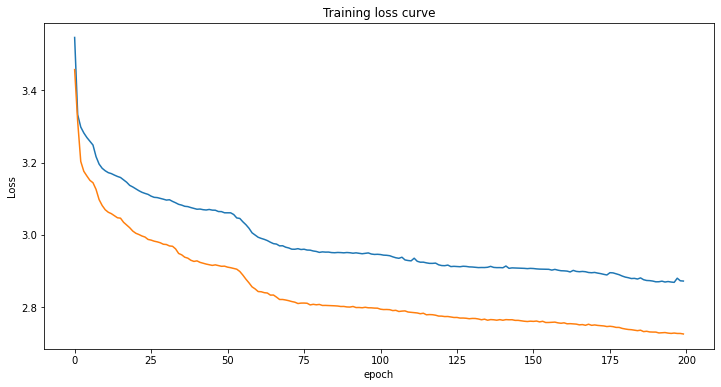

In [18]:
import matplotlib.pyplot as plt
# training_total_loss = [ i.detach().numpy() for i in training_all_loss]
plt.figure(figsize = (12,6))
plt.plot(range(len(validation_all_loss)),validation_all_loss)
plt.plot(range(len(training_all_loss)),training_all_loss)
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title('Training loss curve')
plt.show()


In [19]:
# import matplotlib.pyplot as plt
# # validation_total_loss = [ i.detach().numpy() for i in validation_all_loss]
# plt.figure(figsize = (12,6))
# plt.plot(range(len(validation_all_loss)),validation_all_loss)
# plt.xlabel("epoch")
# plt.ylabel("Loss")
# plt.title('Validation loss curve')
# plt.show()


import torchvision.transforms as T

        
def calculate_metrics(model):

    cal_metrics=calculate()
    model.to(device)
#     print("here")
    with torch.set_grad_enabled(False):
        model.eval()
#         print("here1")
        count=0
        for batch,labels in train_gen:
    #             print("here2")
            count+=1
            batch=batch.float().to(device)
#             batch = F.normalize(batch,mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
            predictions=model(batch)
            predicted_masks=torch.argmax(predictions,dim=1).type(torch.float)
            labels = labels.squeeze(1).to(device)
            cal_metrics.add(predicted_masks.cpu(),labels.cpu()) 
        print("Training set: miou,maccuracy,accuracy: ",cal_metrics.calculate_accuracy())

    cal_metrics_=calculate()
    with torch.set_grad_enabled(False):
        model.eval()
#         print("here1")
        count=0
        for batch,labels in test_gen:
    #             print("here2")
            count+=1
            batch=batch.float().to(device)
#             batch = F.normalize(batch,mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
            predictions=model(batch)
            predicted_masks=torch.argmax(predictions,dim=1).type(torch.float)
            labels = labels.squeeze(1).to(device)
            cal_metrics_.add(predicted_masks.cpu(),labels.cpu()) 
        print("Testing set: miou,maccuracy,accuracy: ",cal_metrics_.calculate_accuracy())

calculate_metrics(model)

Training set: miou,maccuracy,accuracy:  (0.428987724110884, 0.428987724110884, 0.7947000151699006)
Testing set: miou,maccuracy,accuracy:  (0.39112423950062336, 0.39112423950062336, 0.740786345108676)


In [20]:
# def Calculate_mIOU(output,target):
#     #flatten the tensor to 1-D arrays
#     k=31
#     output = output.flatten().clone()
#     target = target.flatten()
#     intersection = output[np.where(output == target)[0]]
#     area_intersection, _ = np.histogram(intersection,bins=np.arange(k+1))
#     area_output,_=np.histogram(output,bins=np.arange(k+1))
#     area_target,_=np.histogram(target,bins=np.arange(k+1))
#     area_union=area_output+area_target-area_intersection
#     return area_intersection,area_union,area_target


import torchvision.transforms.functional as F

testing_total_loss=0
testing_loss=0
model.to(device)
model.eval()
print("here")
with torch.set_grad_enabled(False):
    print("here1")
    for batch,labels in test_gen:
#             print("here2")
        batch=batch.float().to(device)
        labels=labels.float()
#         labels = ((labels - labels.min()) * (1/(labels.max() - labels.min())*30))
#         print("batch size", batch.size())
#             batch,label=Variable(batch,requires_grad=True),Variable(labels,requires_grad=True)
#             print(batch,label)
        predictions=model(batch)
#             print("predictions" ,predictions)
#             print("predictions size",predictions.size())
#             print("norm_pred",norm_pred.size())
#         npred = torch.argmax(predictions.squeeze(),dim=1)
        predictions = predictions.type(torch.FloatTensor)
        npred = torch.nn.functional.softmax(predictions,dim =1).to(device)
        print("np ", npred.size())
        labels = labels.squeeze(1).to(device)

        pred_loss = lossfunc(npred,labels.long()) 
#         testing_loss.append(pred_loss)
        print("pred_loss",pred_loss)
#         print("batch[0]",batch[0])
        masks = [
            npred[img_idx,sem_class_to_idx[cls]]
            for img_idx in range(batch.shape[0])
            for cls in classes]
        break

here
here1
np  torch.Size([20, 31, 32, 32])
pred_loss tensor(2.6665)


<ipython-input-21-752cab944f92>:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)


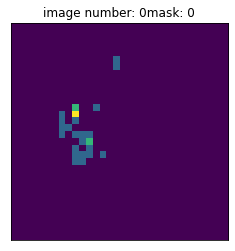

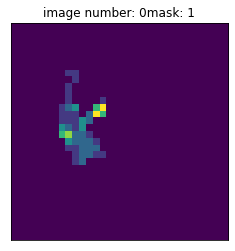

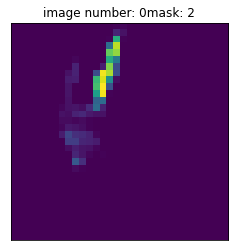

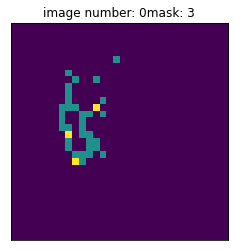

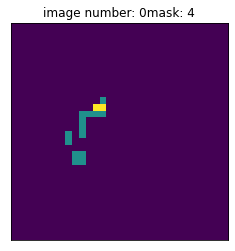

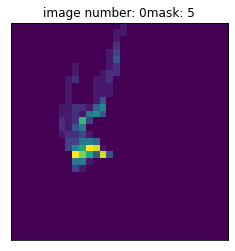

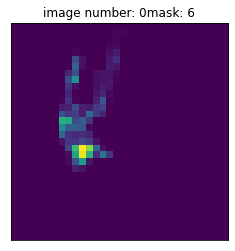

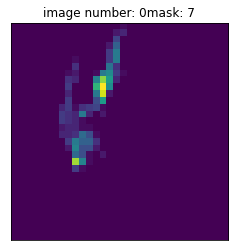

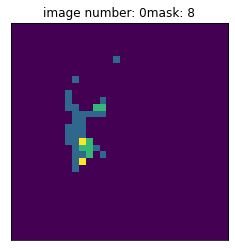

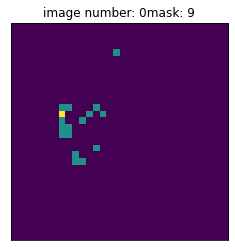

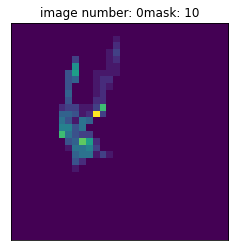

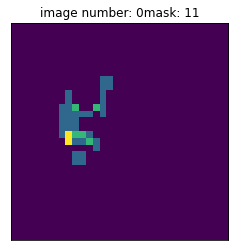

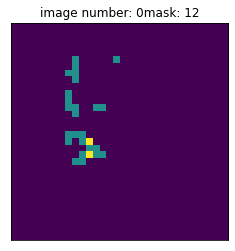

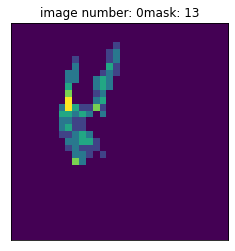

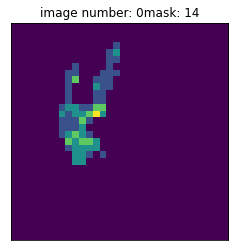

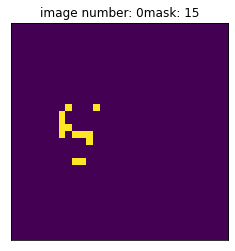

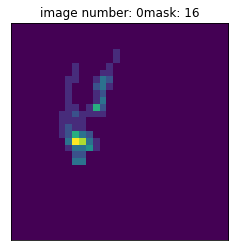

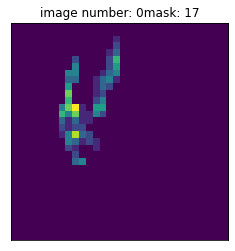

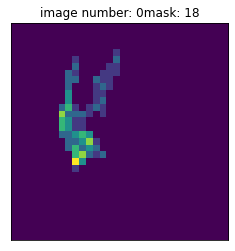

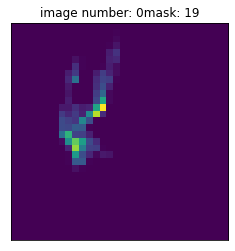

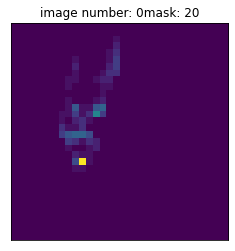

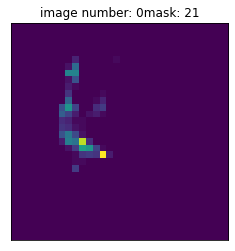

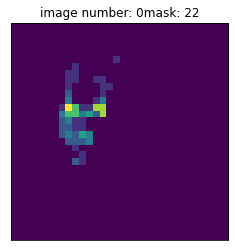

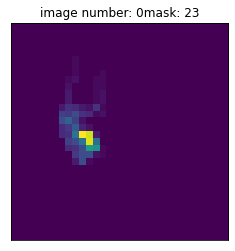

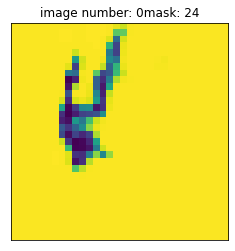

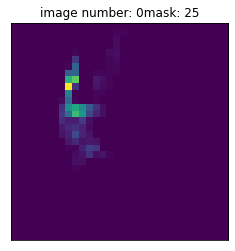

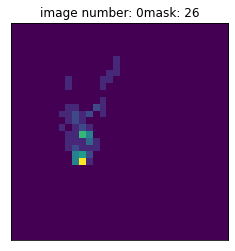

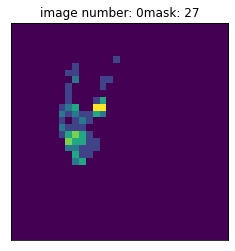

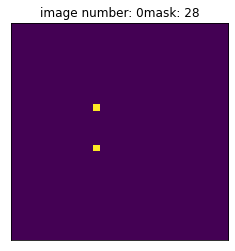

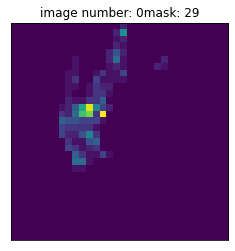

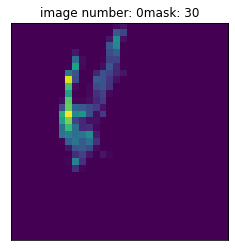

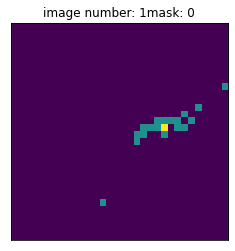

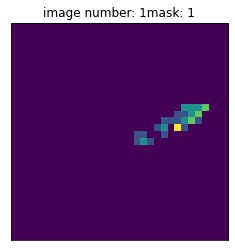

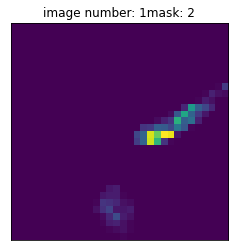

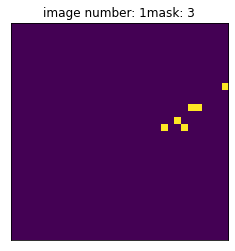

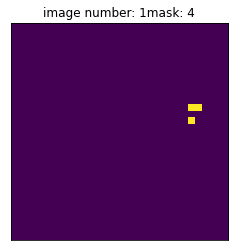

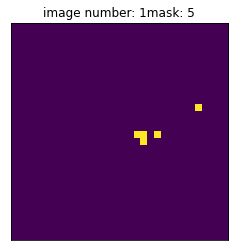

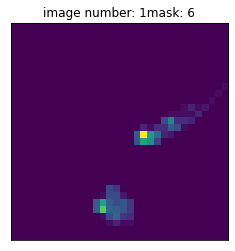

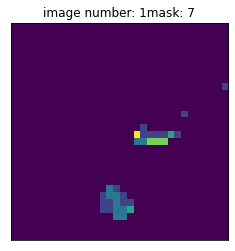

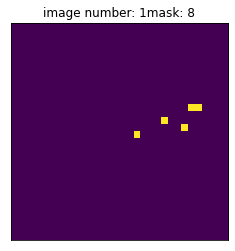

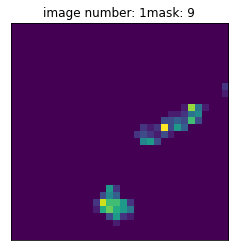

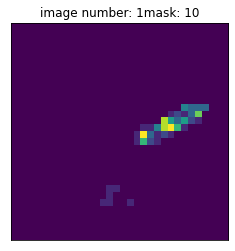

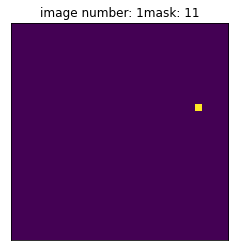

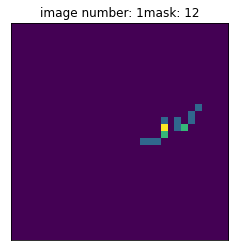

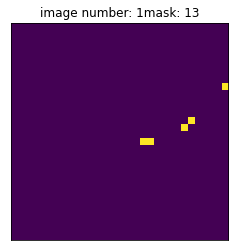

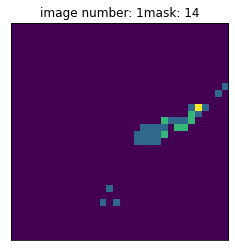

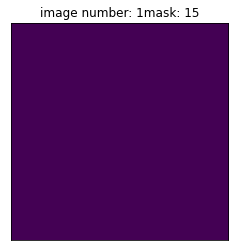

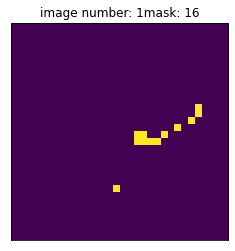

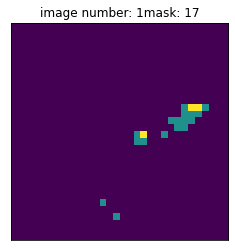

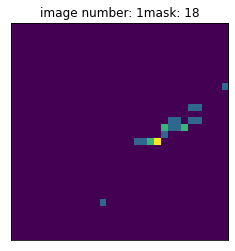

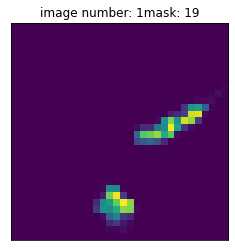

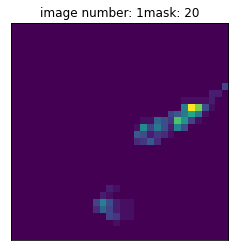

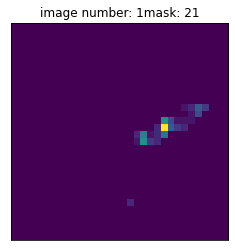

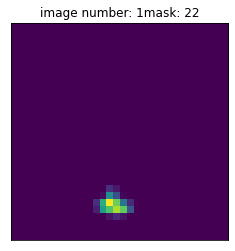

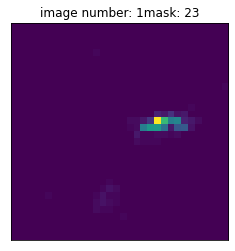

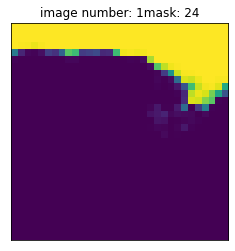

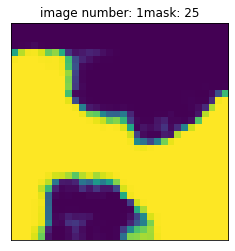

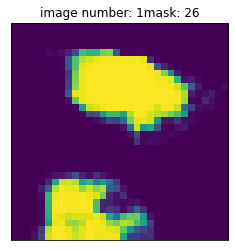

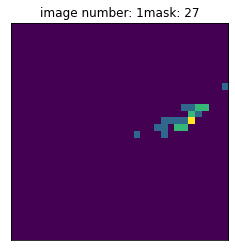

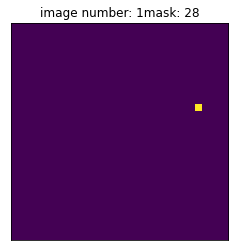

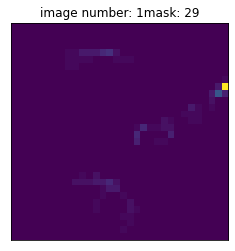

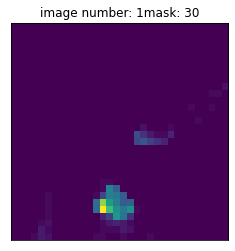

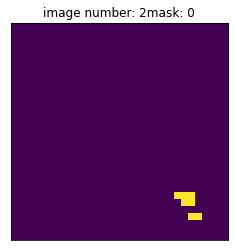

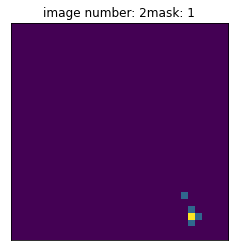

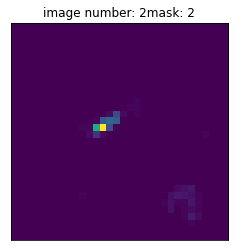

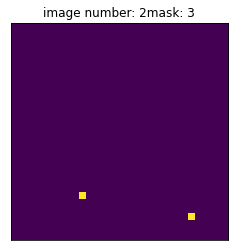

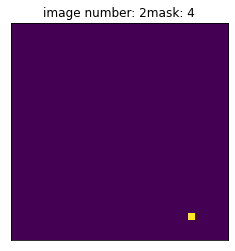

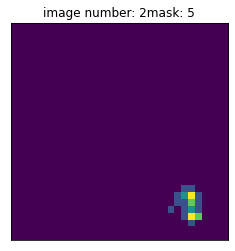

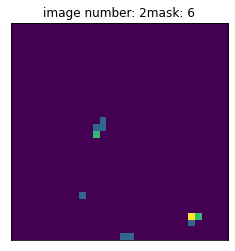

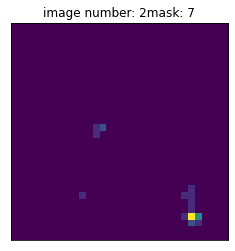

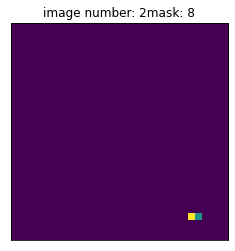

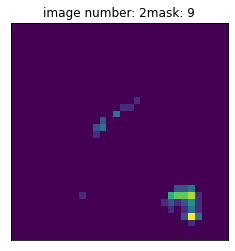

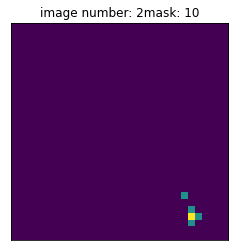

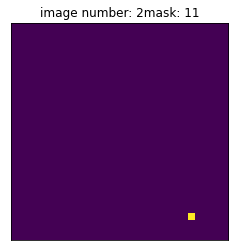

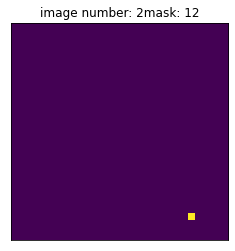

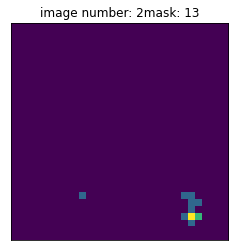

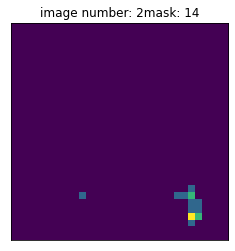

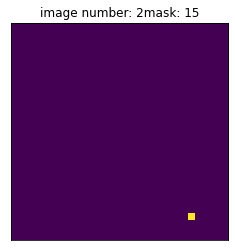

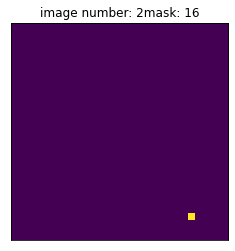

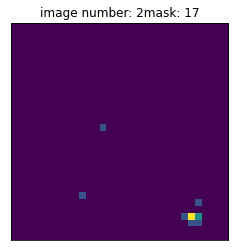

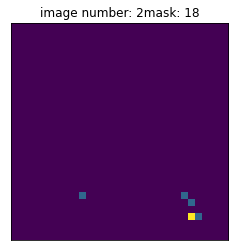

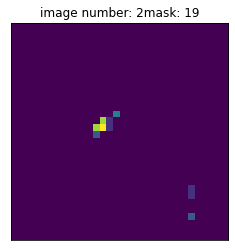

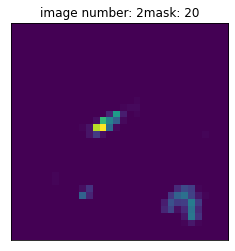

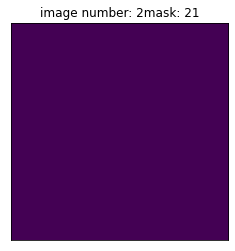

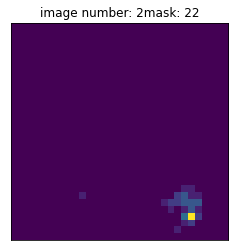

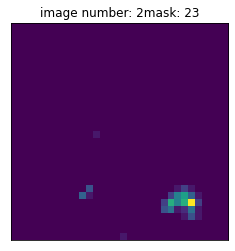

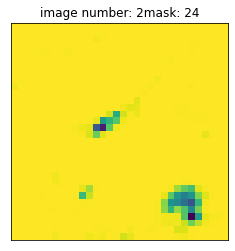

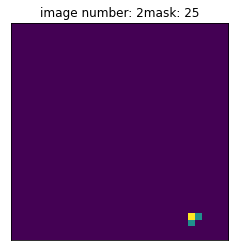

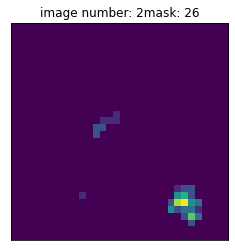

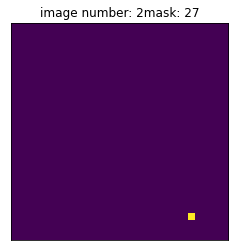

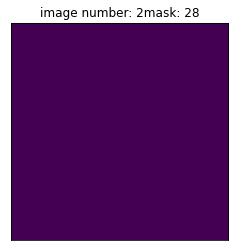

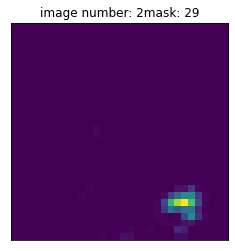

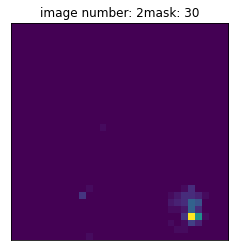

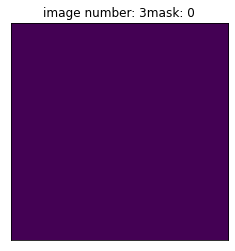

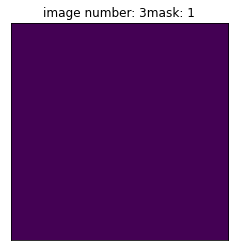

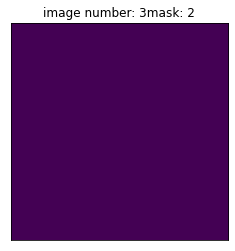

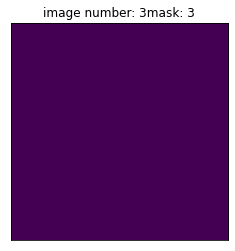

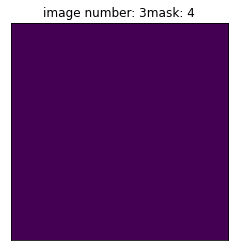

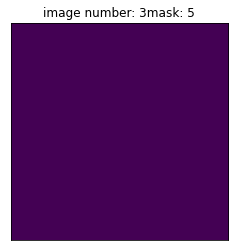

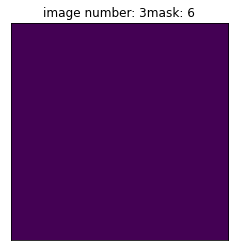

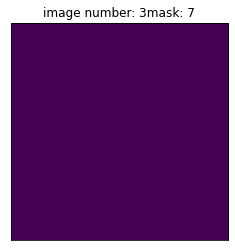

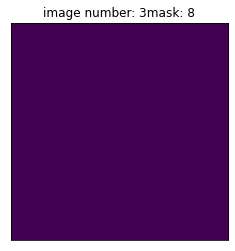

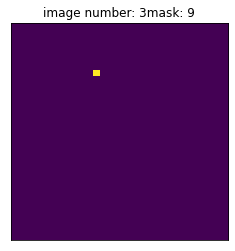

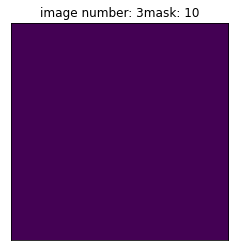

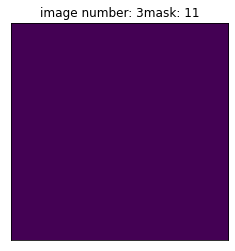

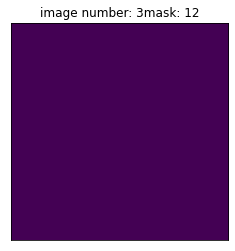

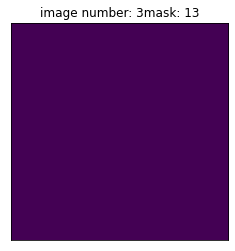

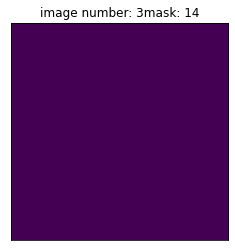

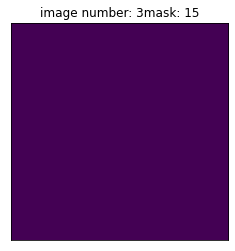

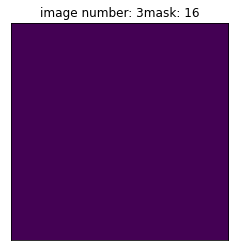

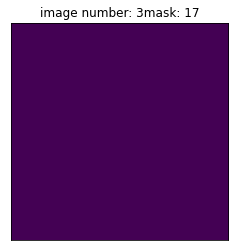

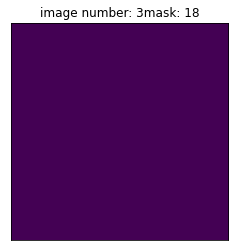

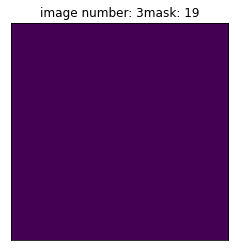

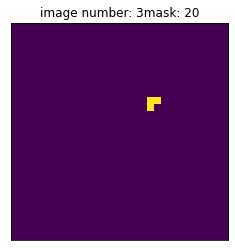

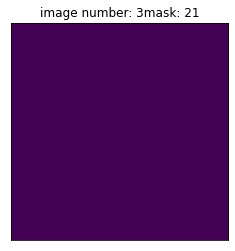

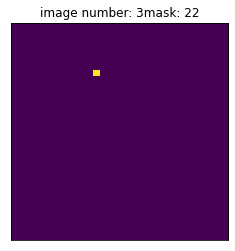

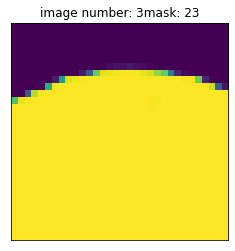

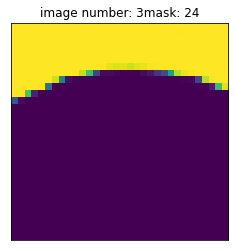

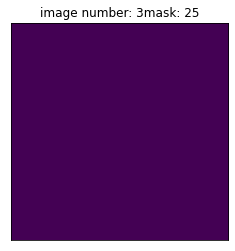

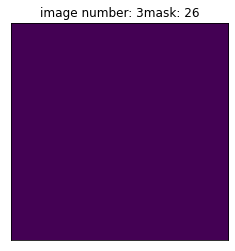

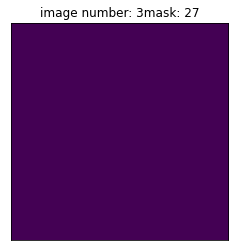

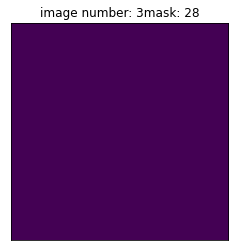

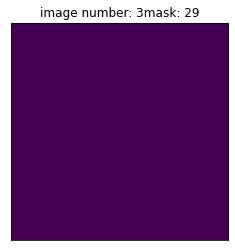

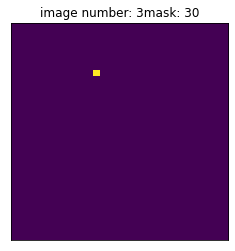

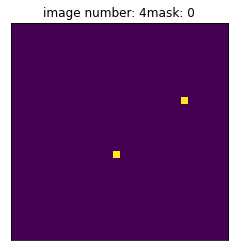

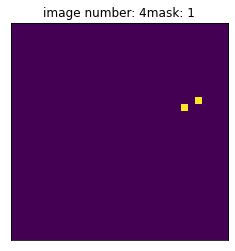

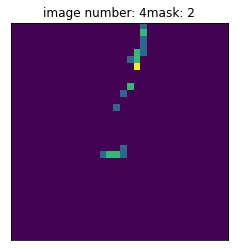

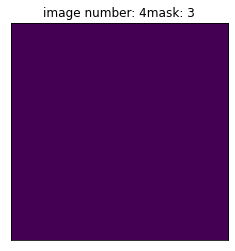

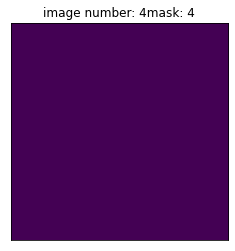

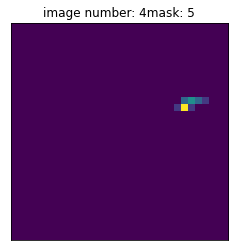

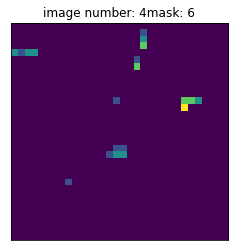

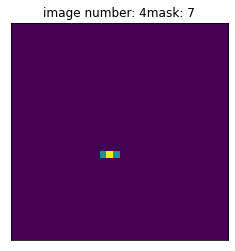

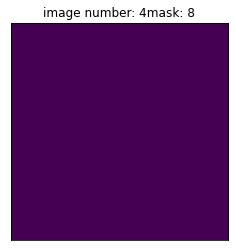

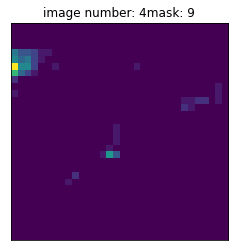

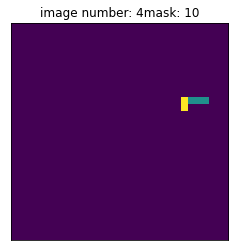

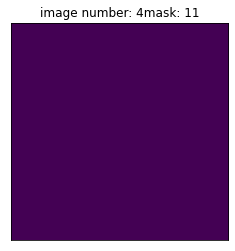

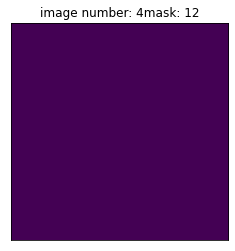

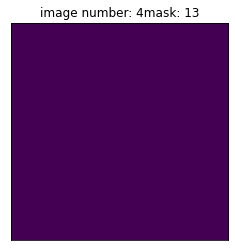

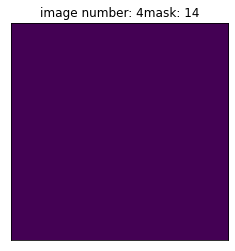

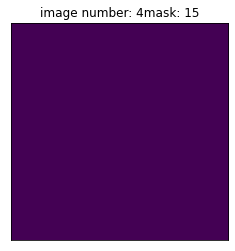

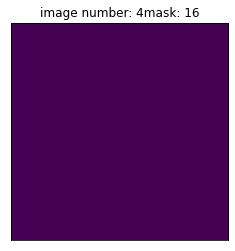

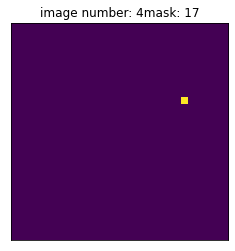

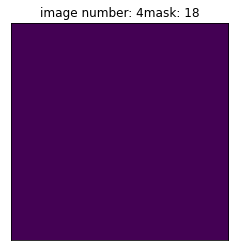

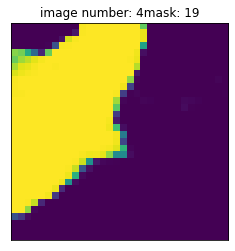

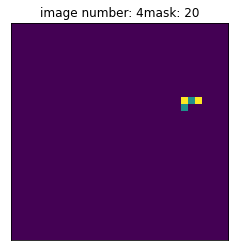

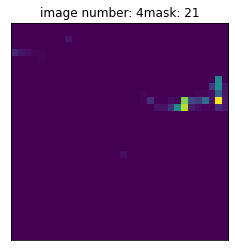

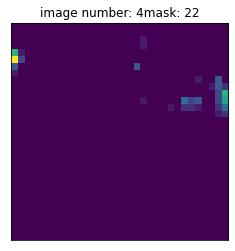

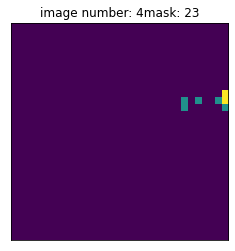

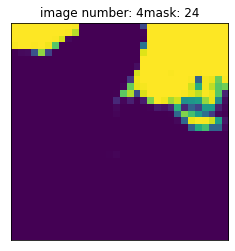

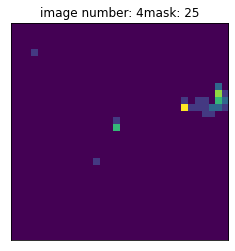

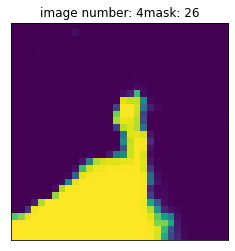

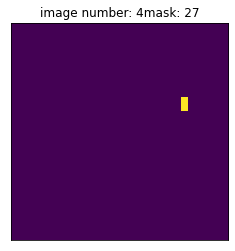

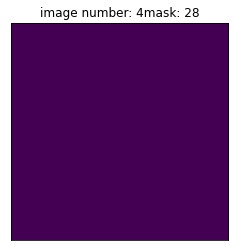

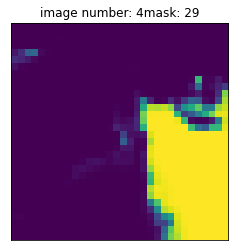

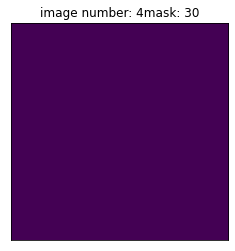

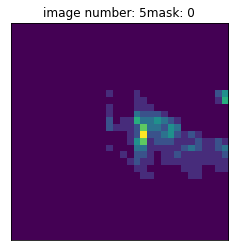

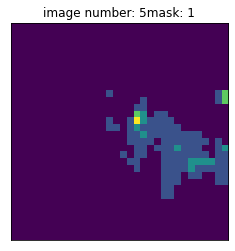

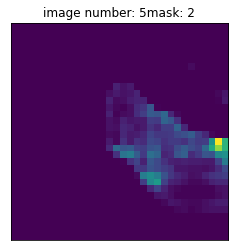

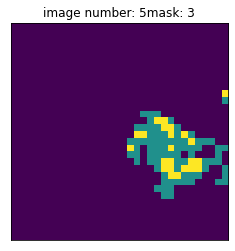

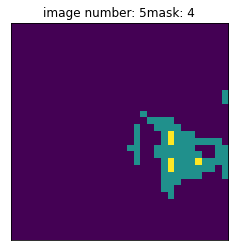

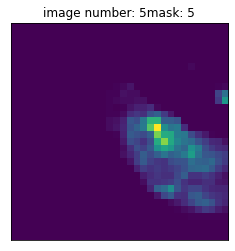

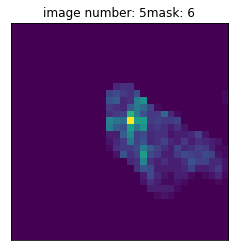

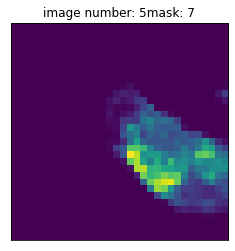

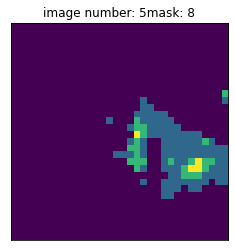

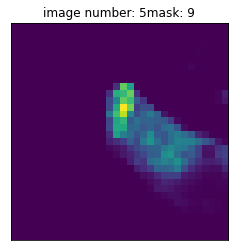

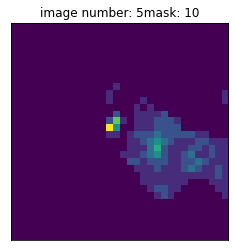

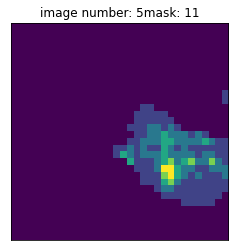

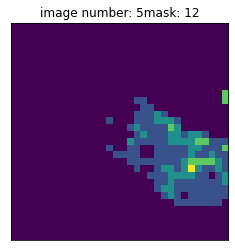

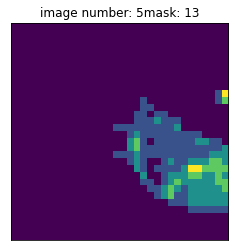

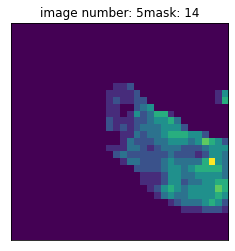

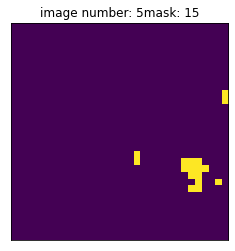

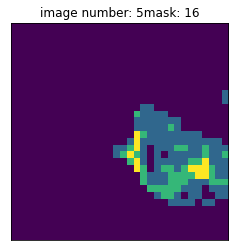

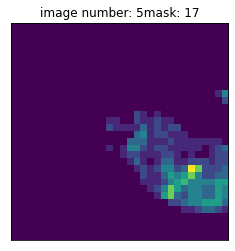

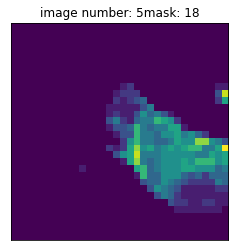

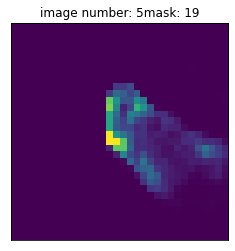

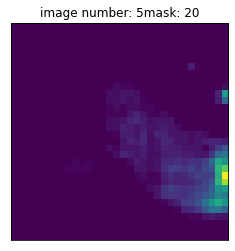

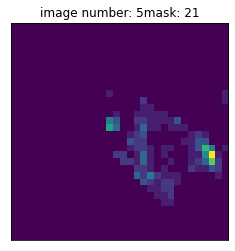

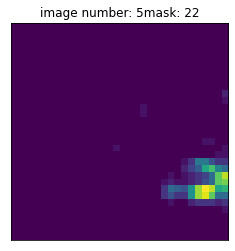

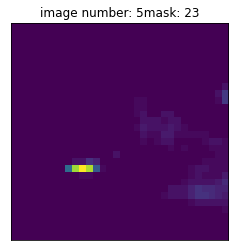

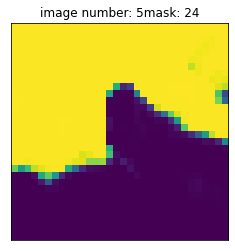

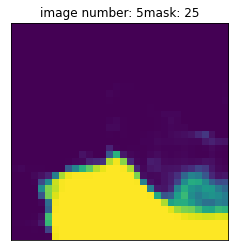

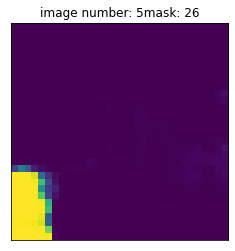

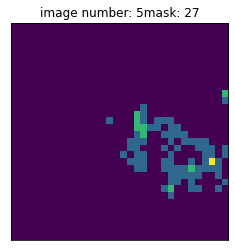

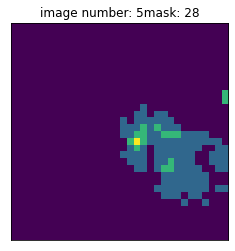

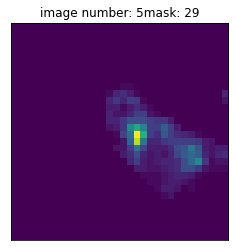

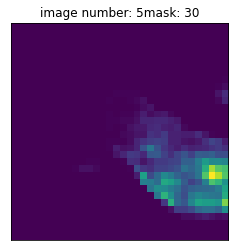

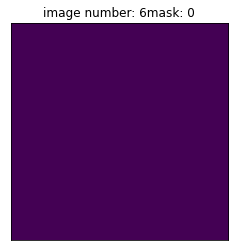

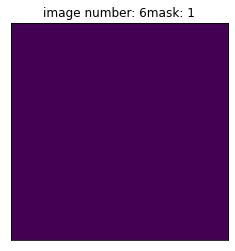

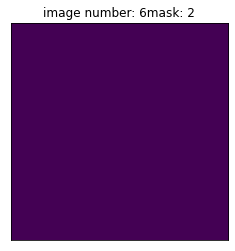

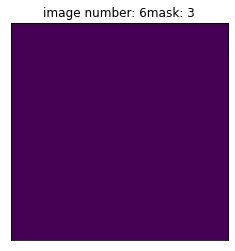

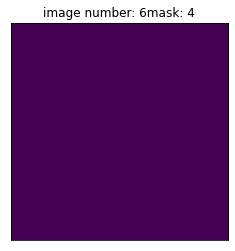

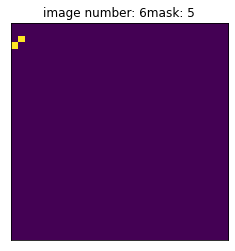

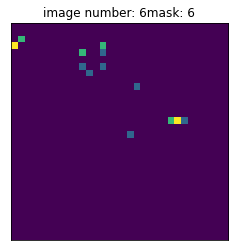

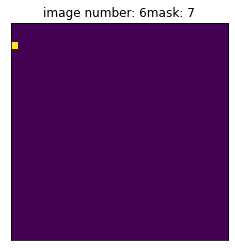

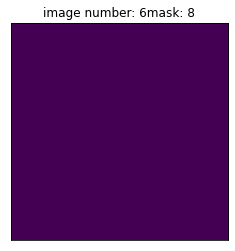

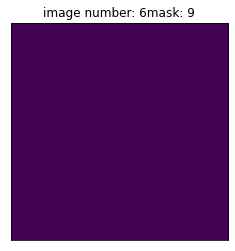

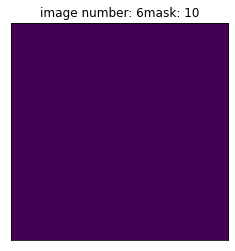

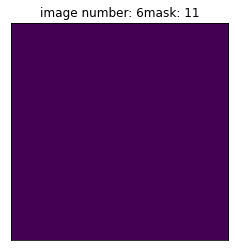

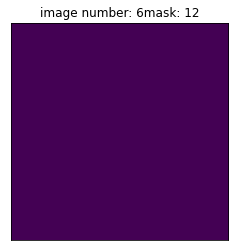

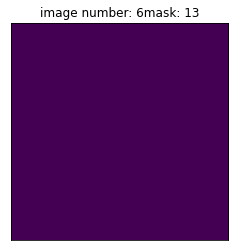

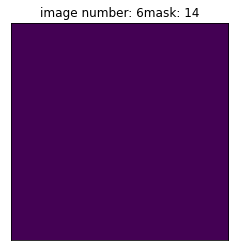

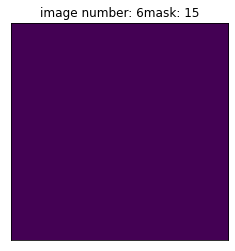

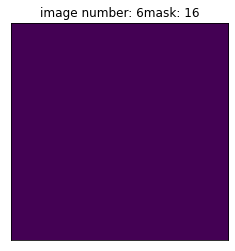

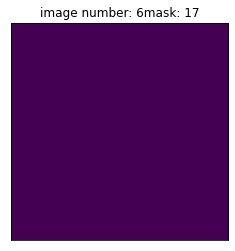

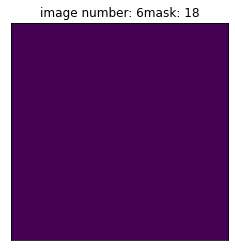

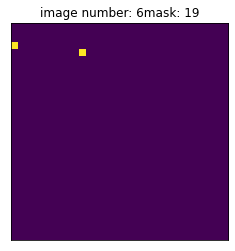

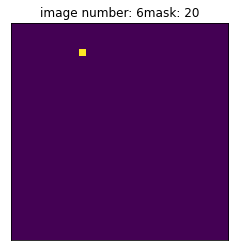

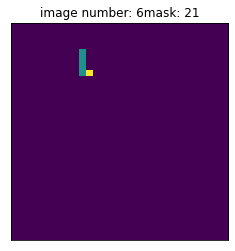

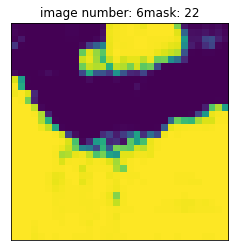

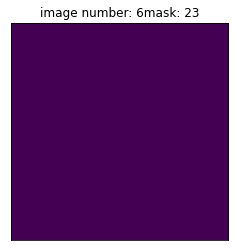

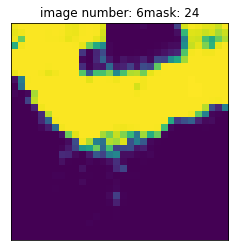

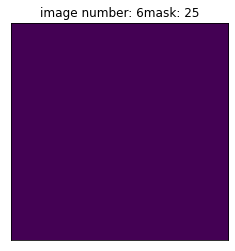

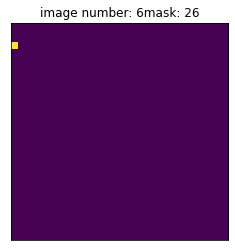

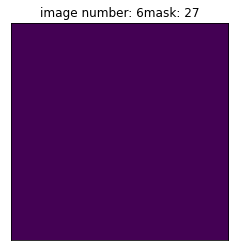

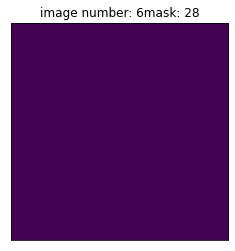

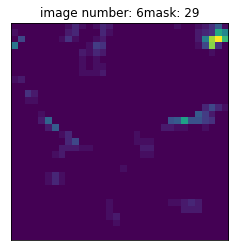

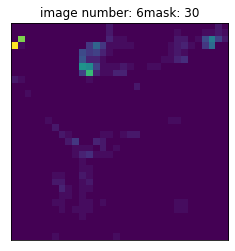

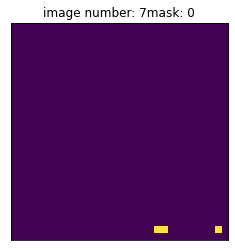

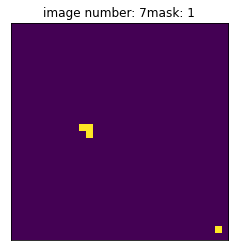

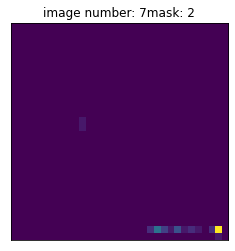

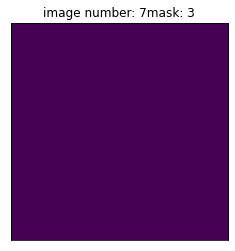

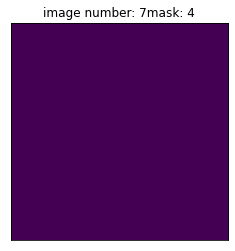

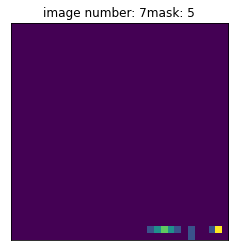

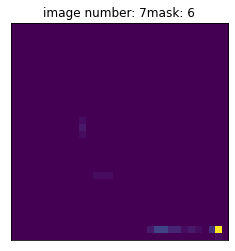

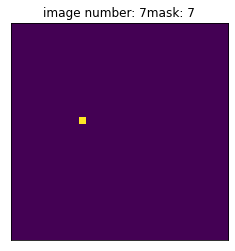

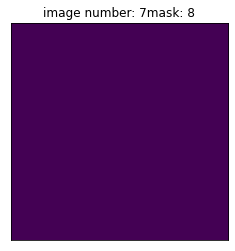

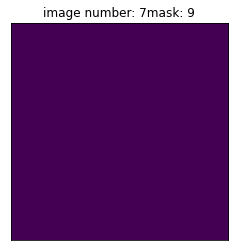

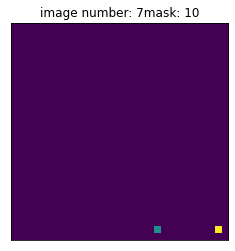

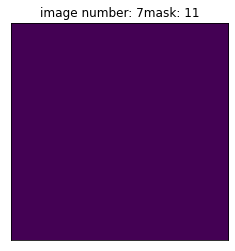

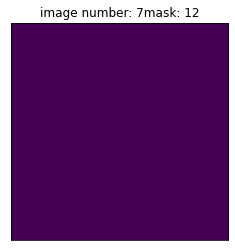

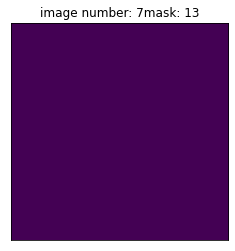

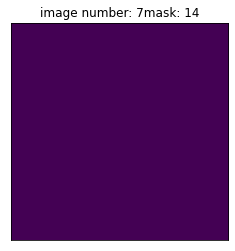

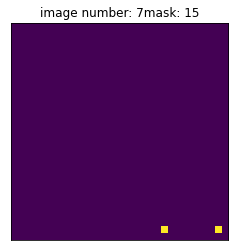

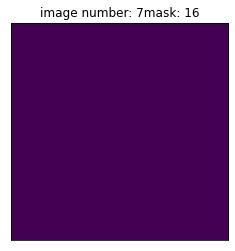

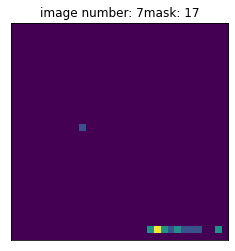

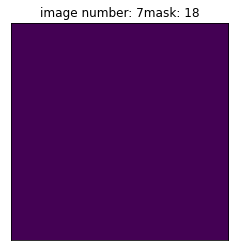

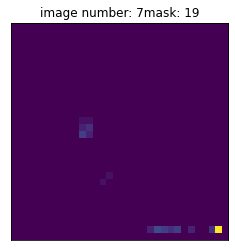

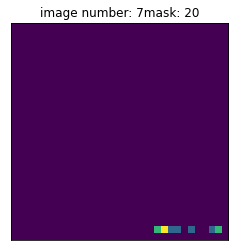

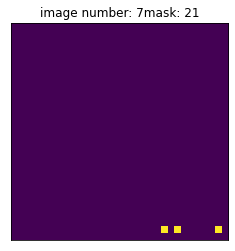

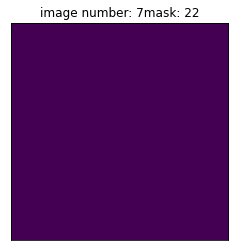

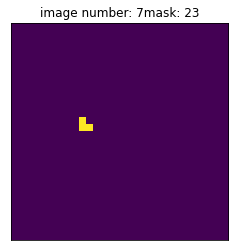

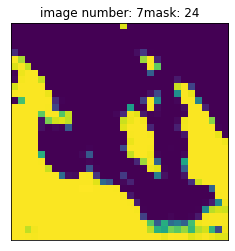

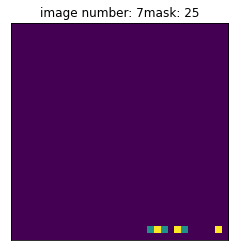

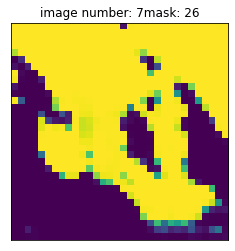

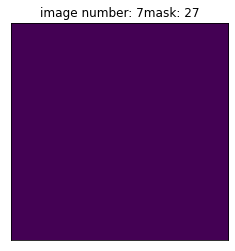

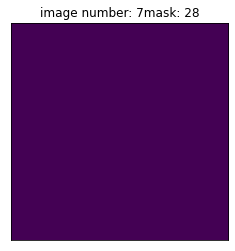

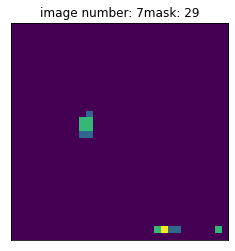

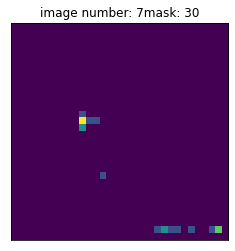

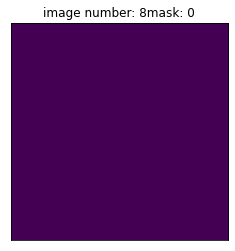

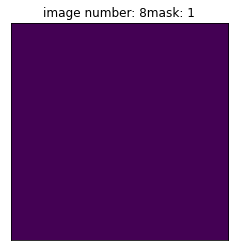

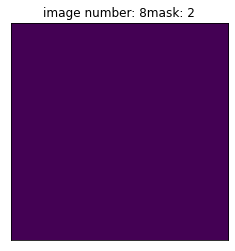

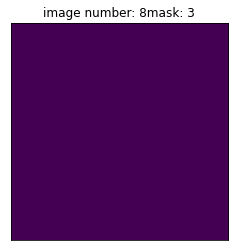

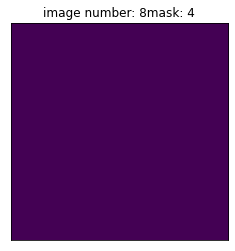

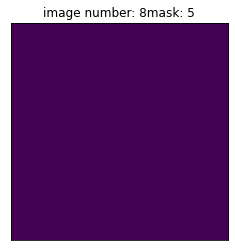

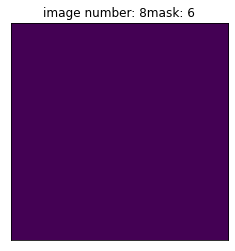

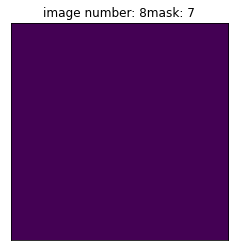

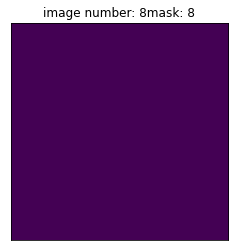

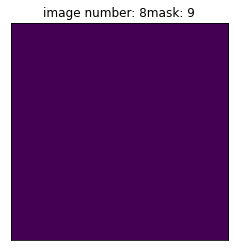

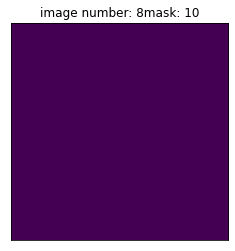

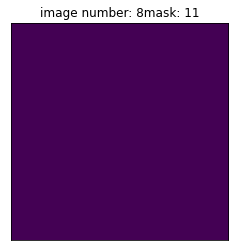

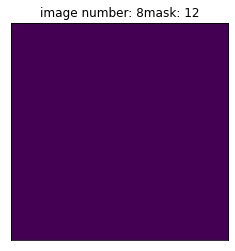

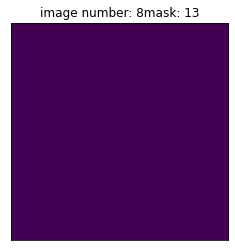

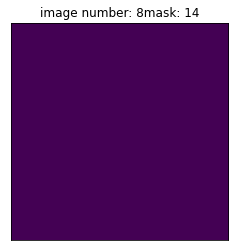

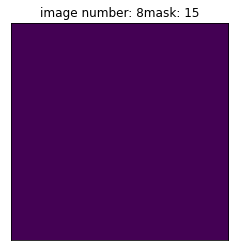

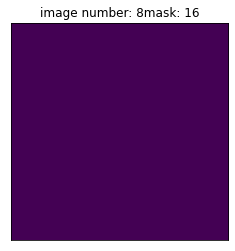

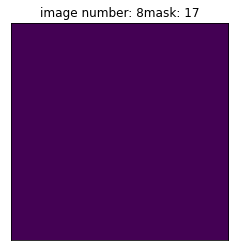

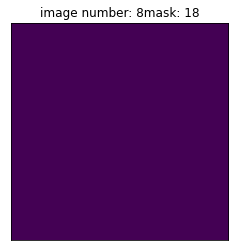

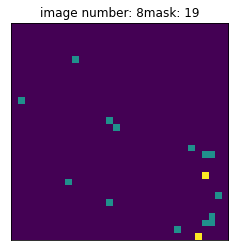

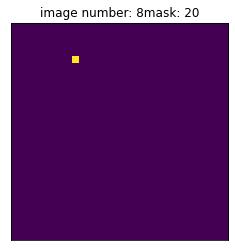

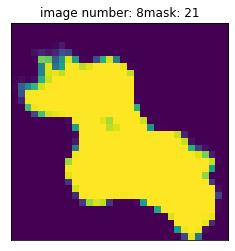

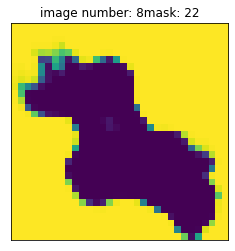

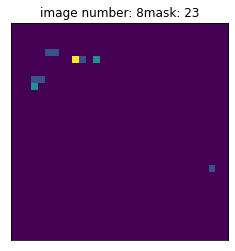

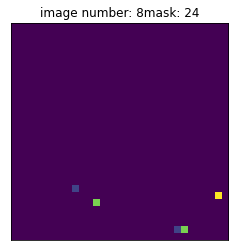

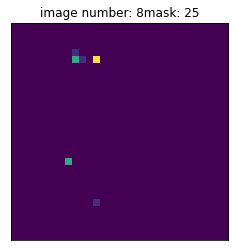

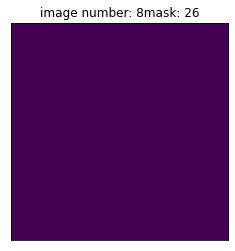

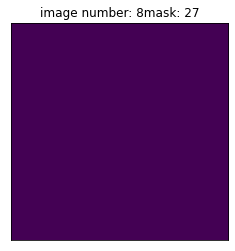

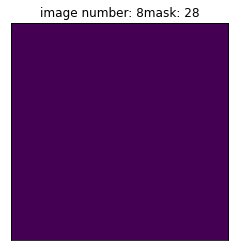

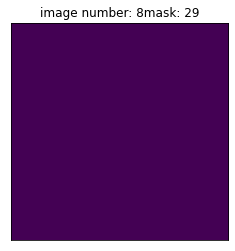

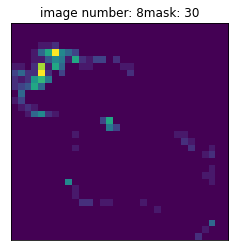

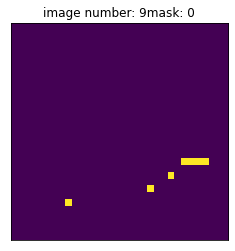

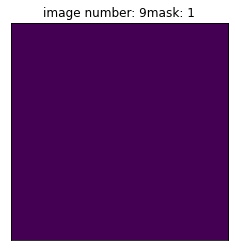

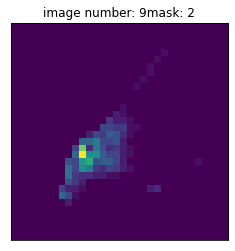

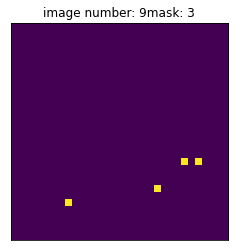

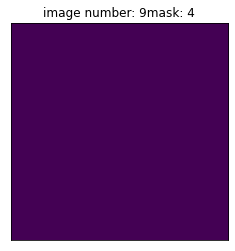

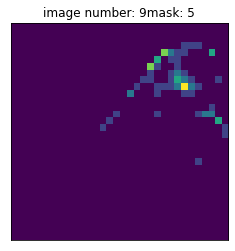

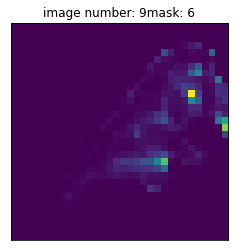

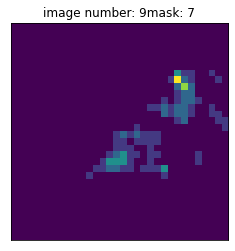

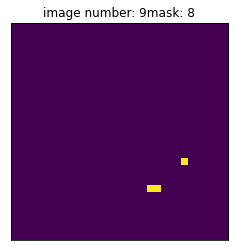

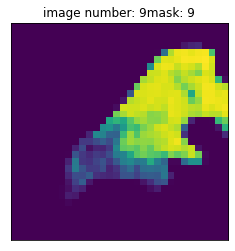

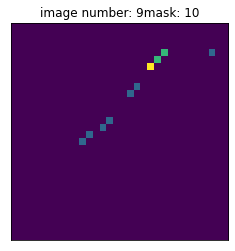

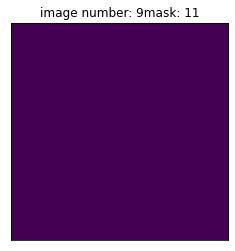

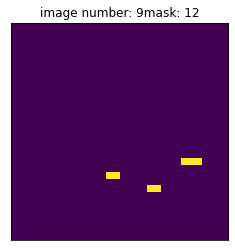

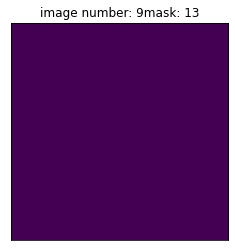

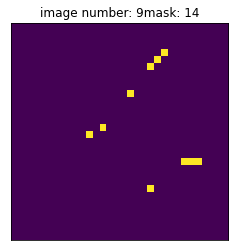

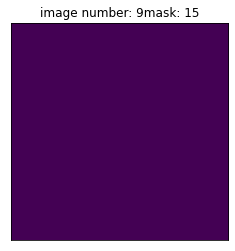

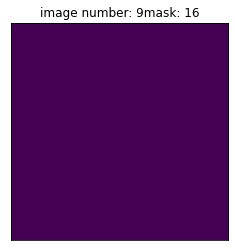

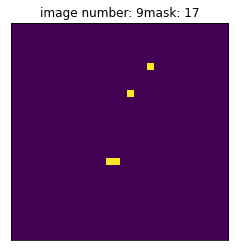

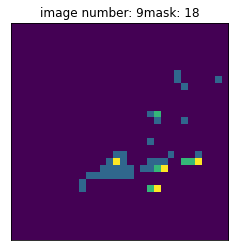

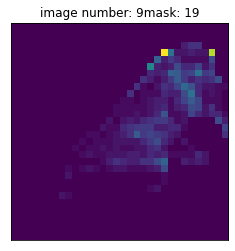

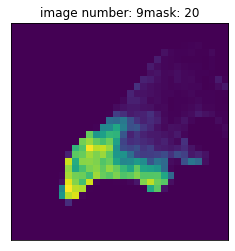

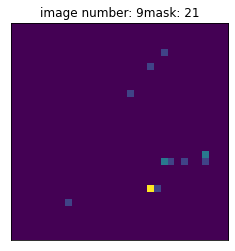

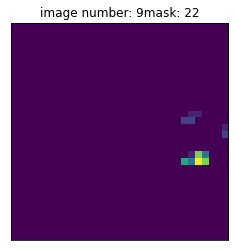

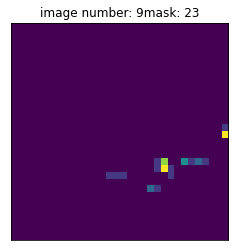

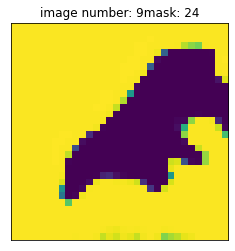

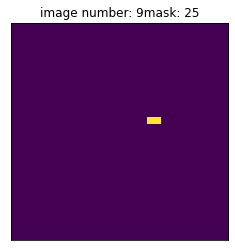

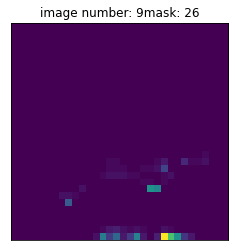

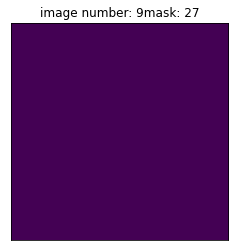

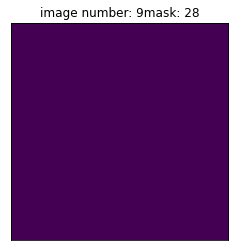

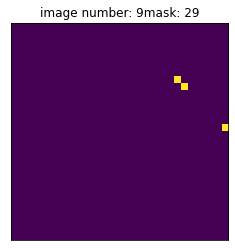

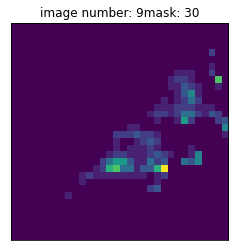

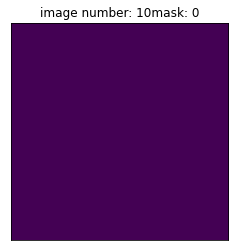

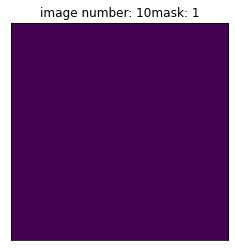

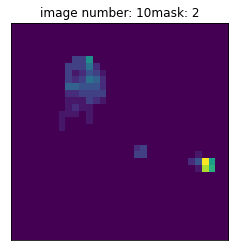

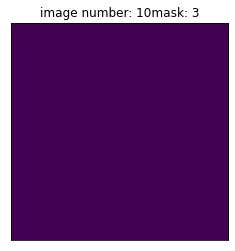

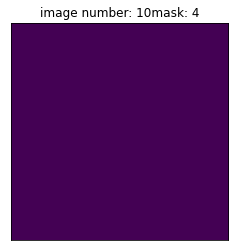

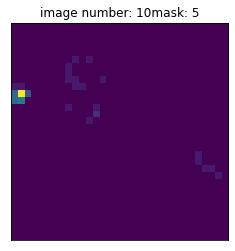

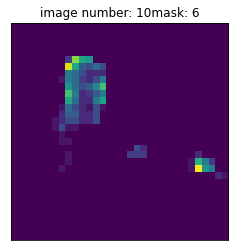

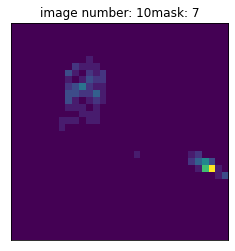

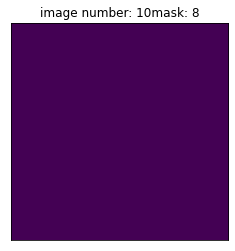

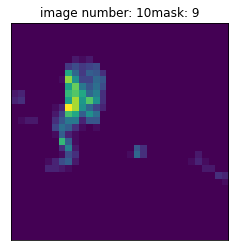

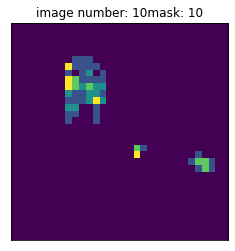

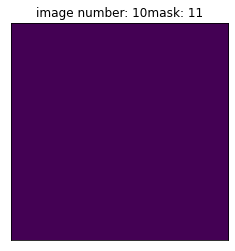

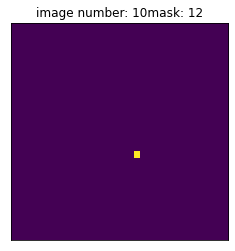

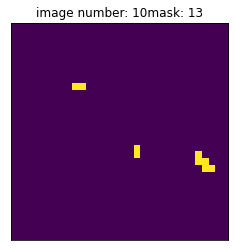

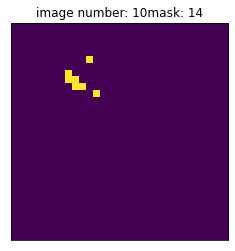

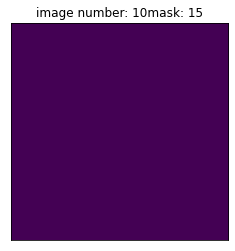

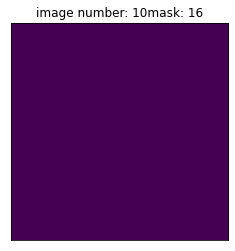

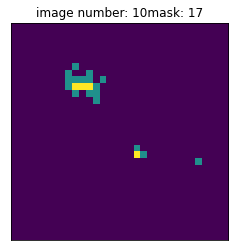

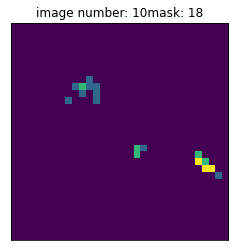

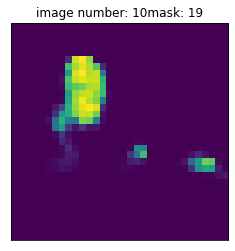

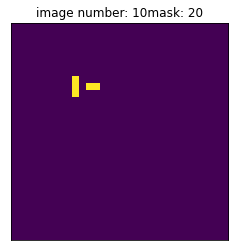

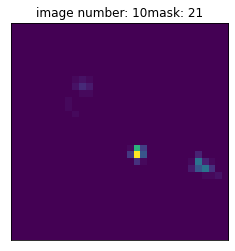

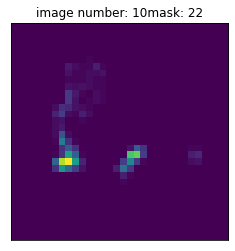

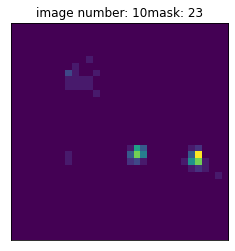

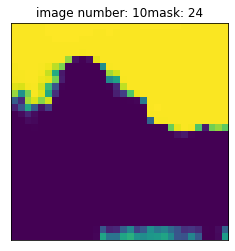

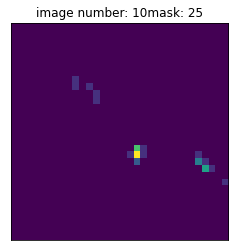

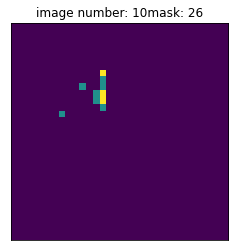

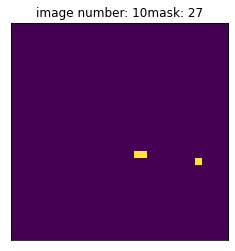

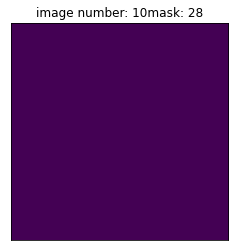

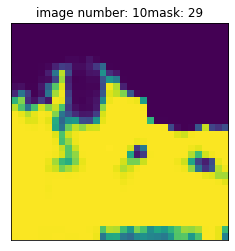

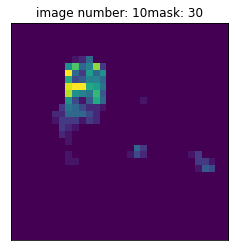

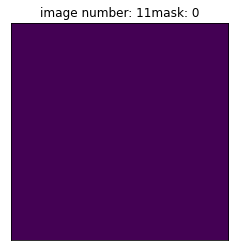

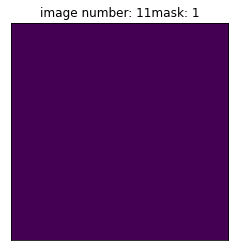

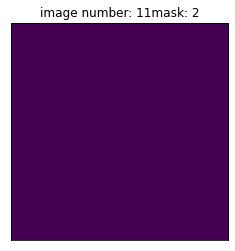

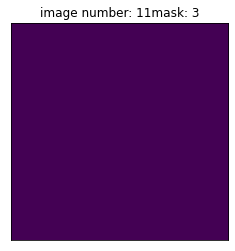

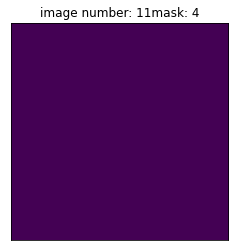

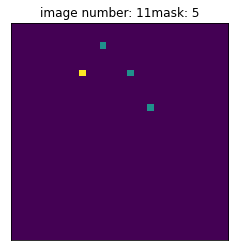

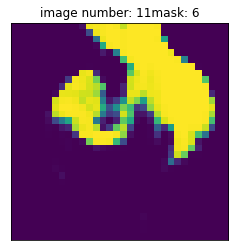

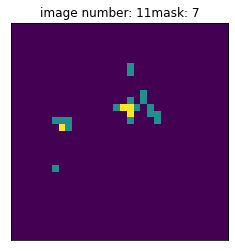

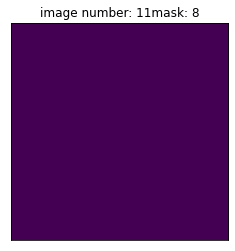

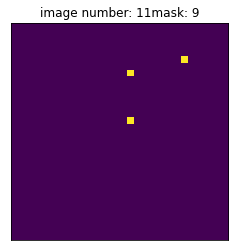

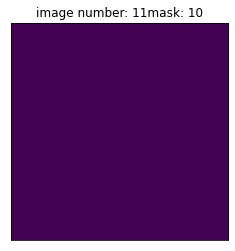

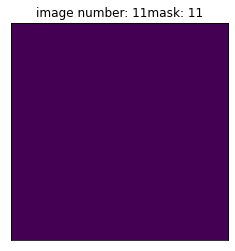

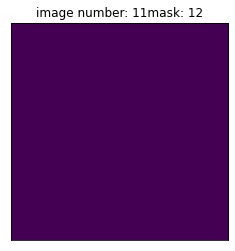

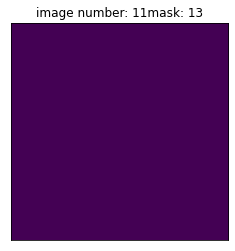

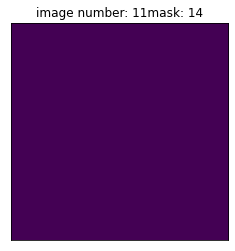

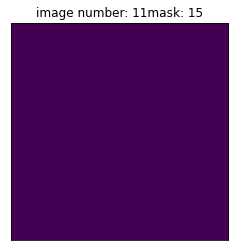

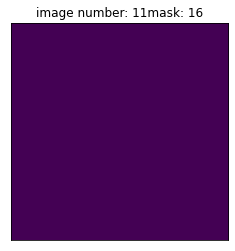

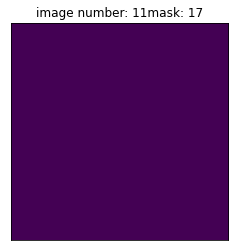

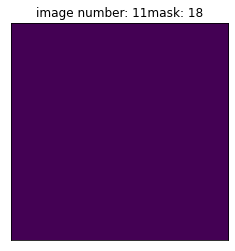

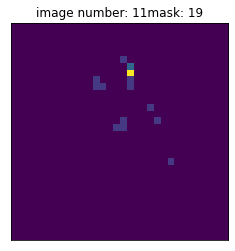

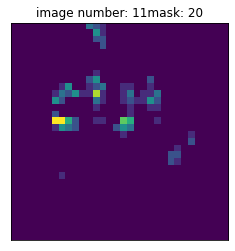

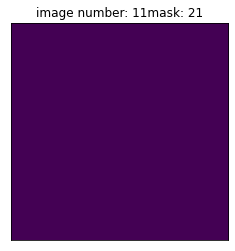

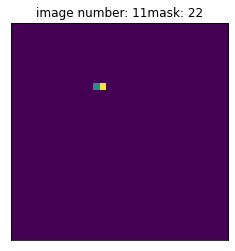

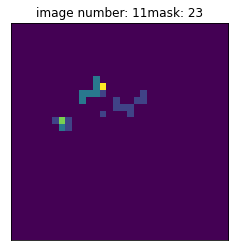

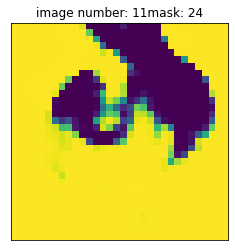

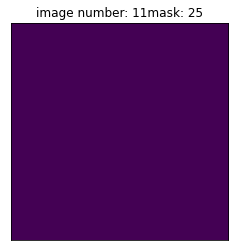

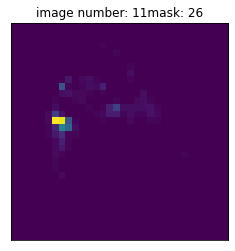

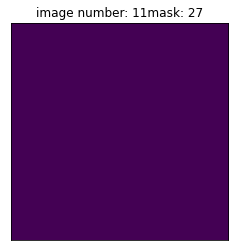

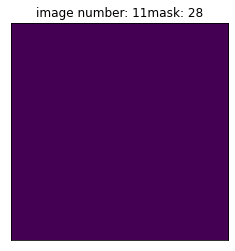

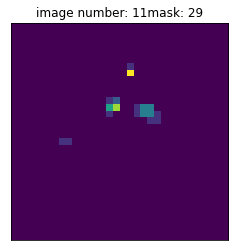

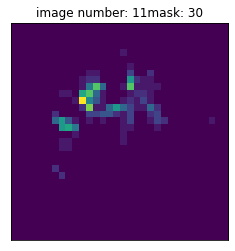

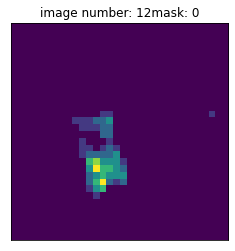

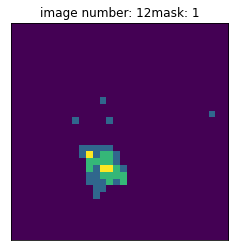

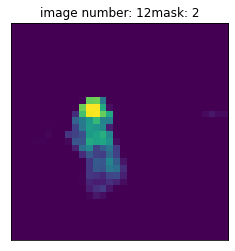

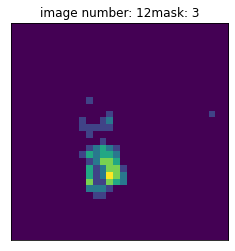

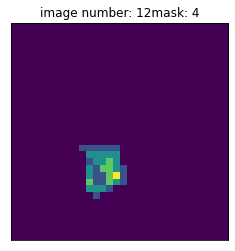

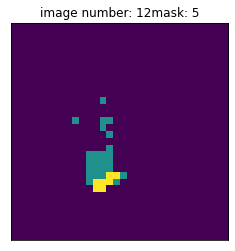

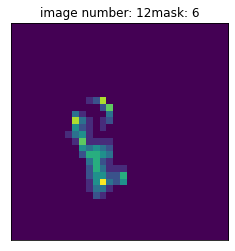

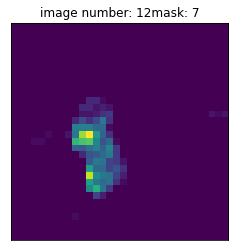

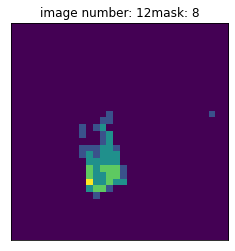

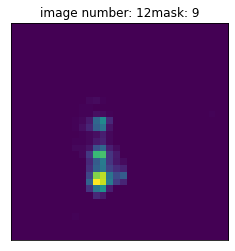

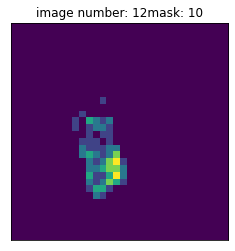

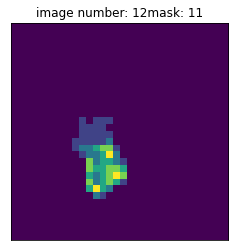

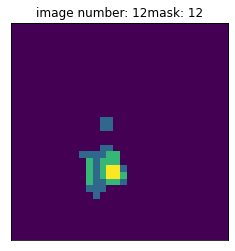

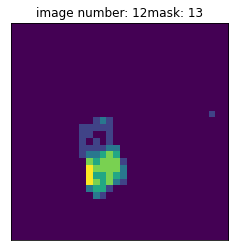

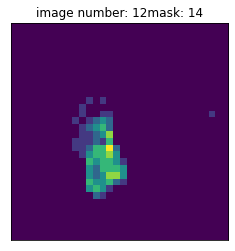

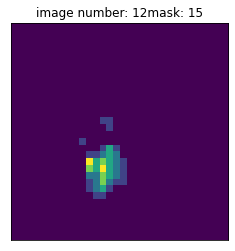

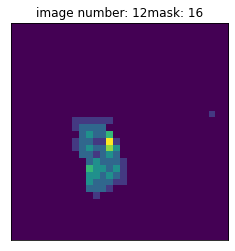

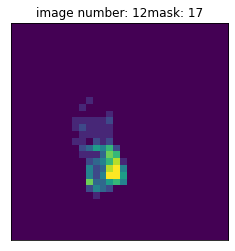

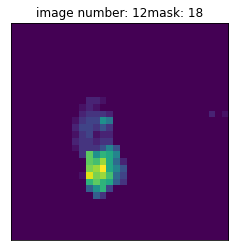

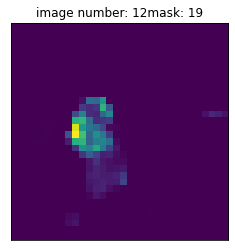

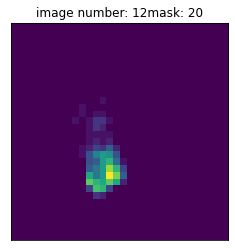

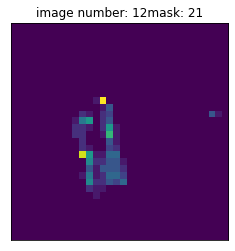

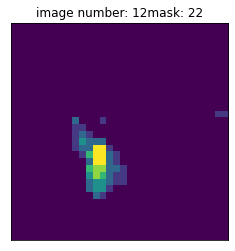

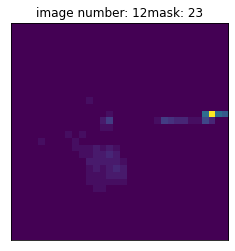

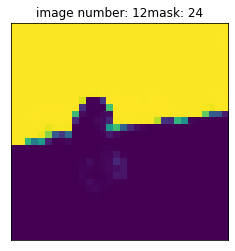

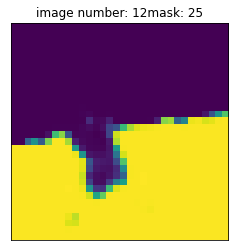

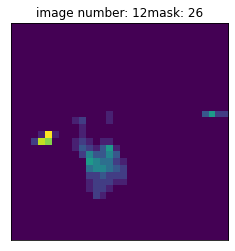

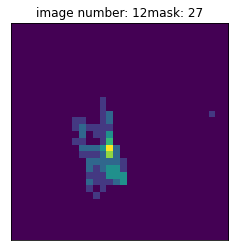

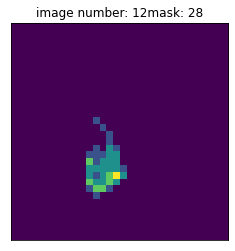

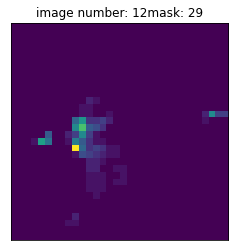

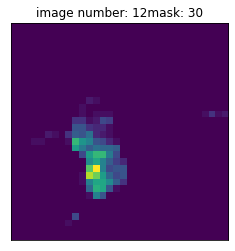

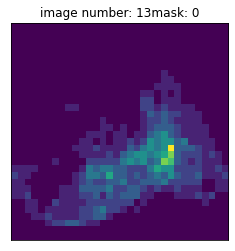

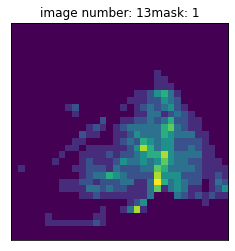

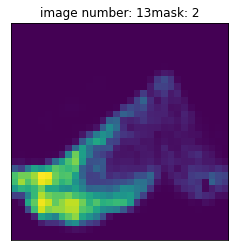

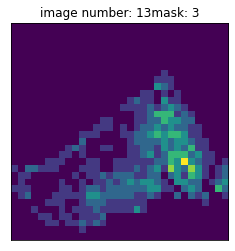

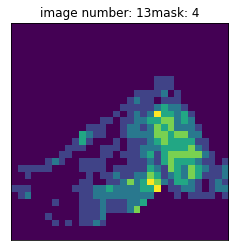

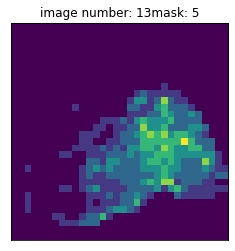

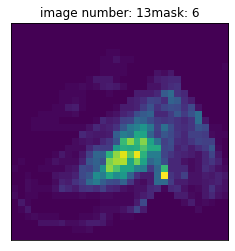

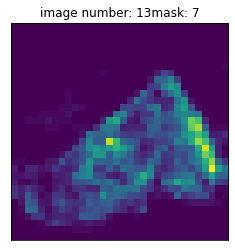

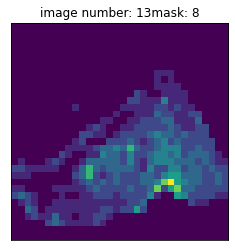

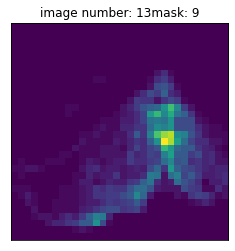

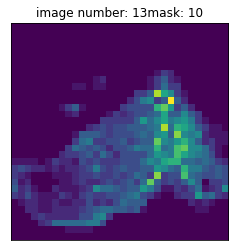

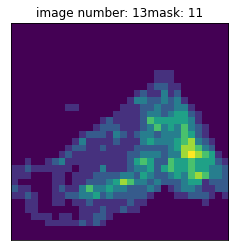

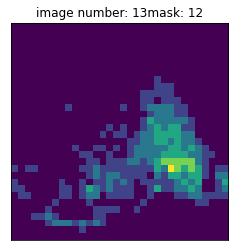

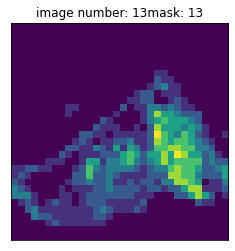

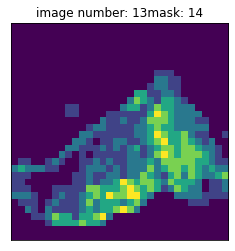

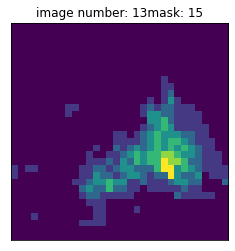

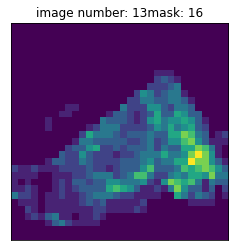

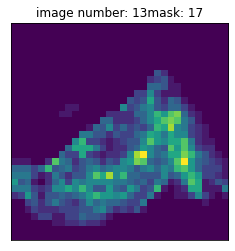

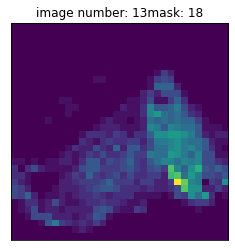

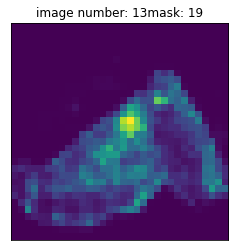

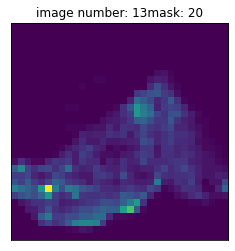

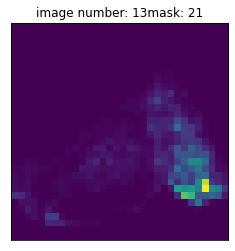

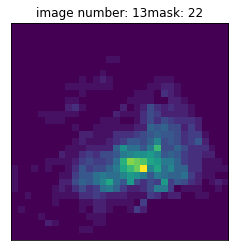

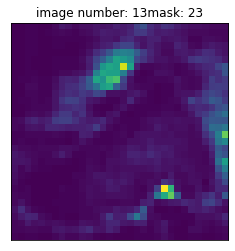

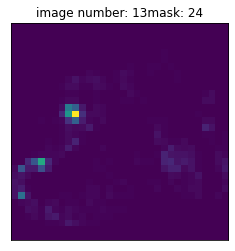

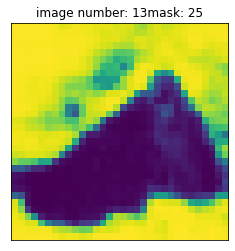

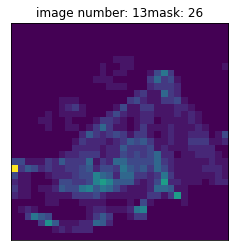

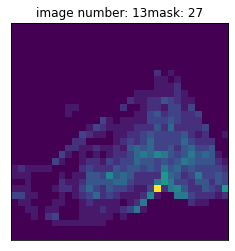

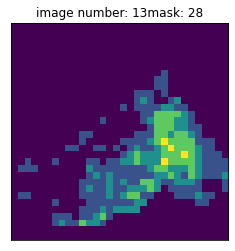

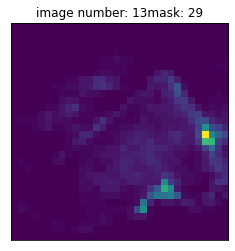

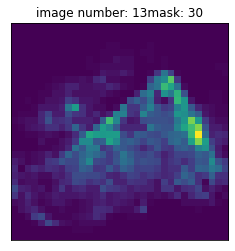

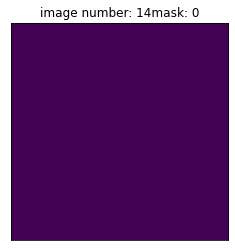

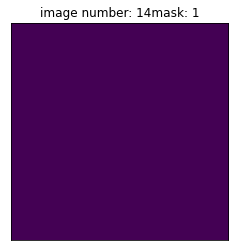

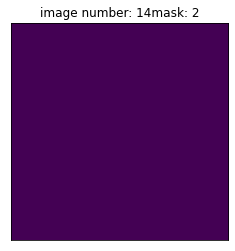

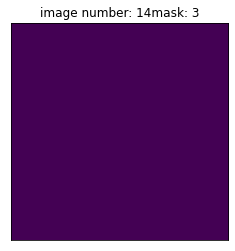

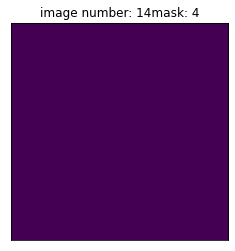

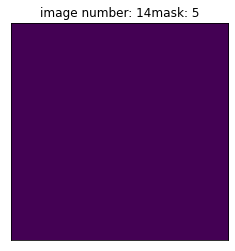

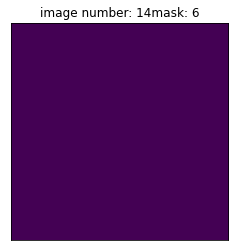

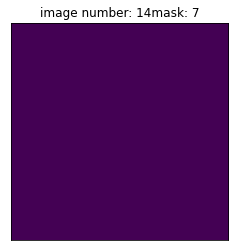

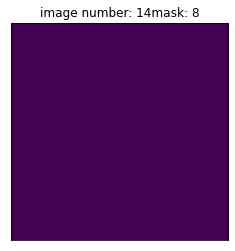

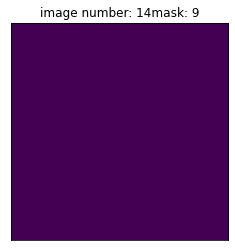

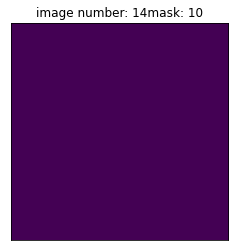

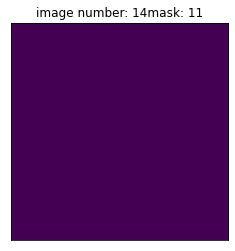

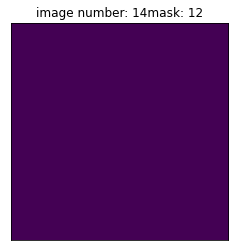

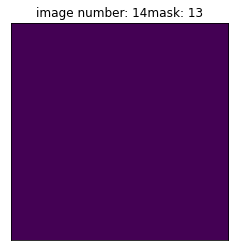

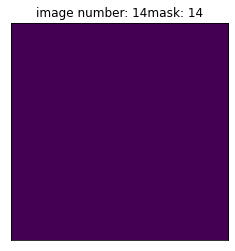

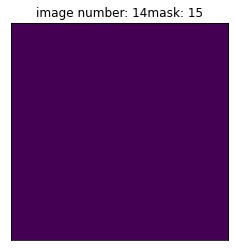

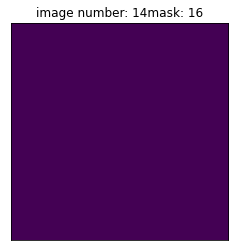

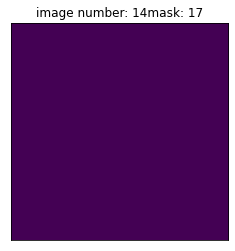

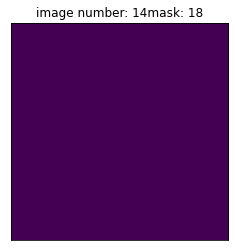

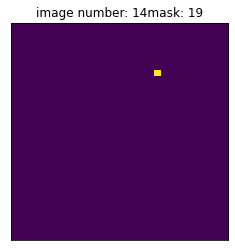

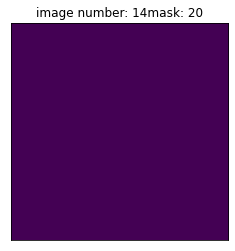

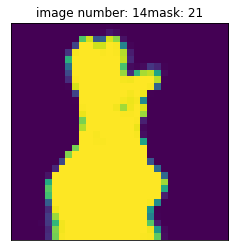

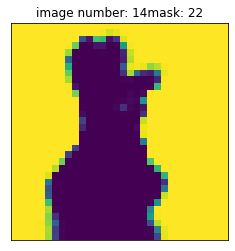

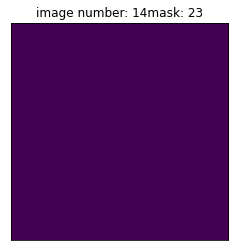

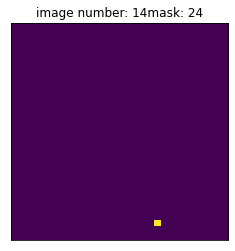

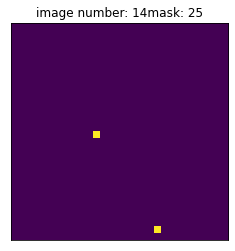

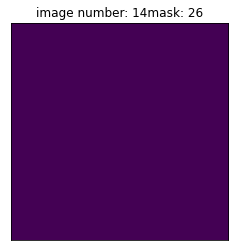

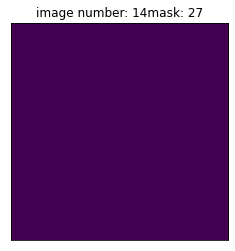

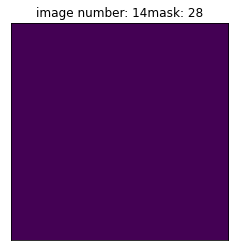

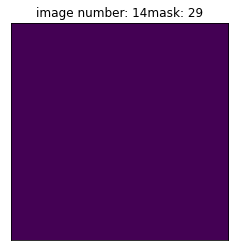

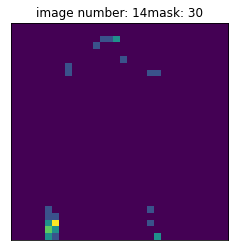

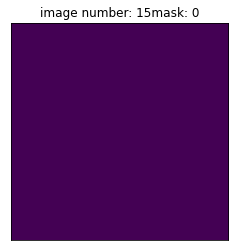

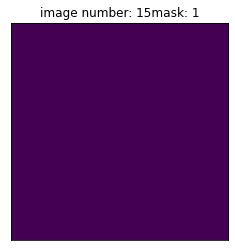

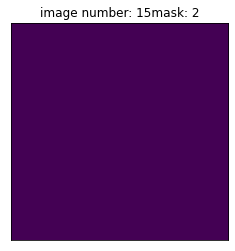

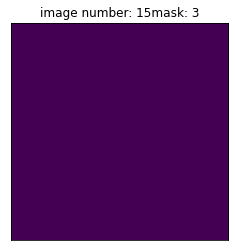

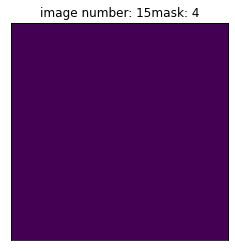

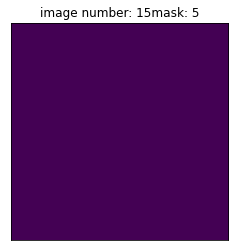

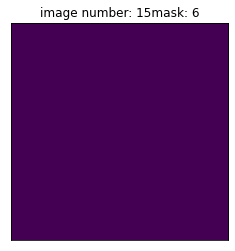

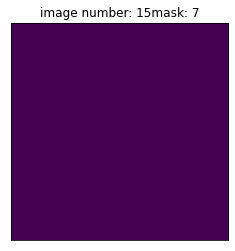

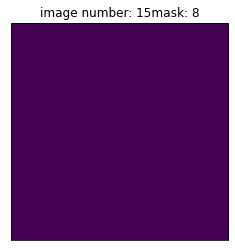

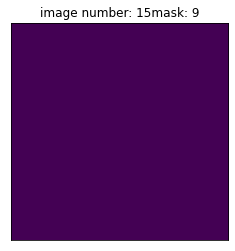

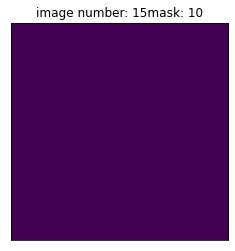

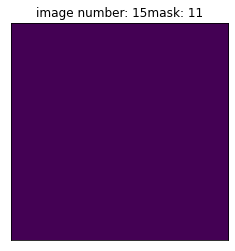

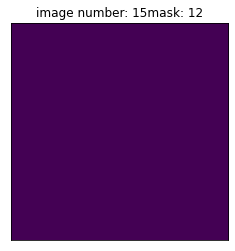

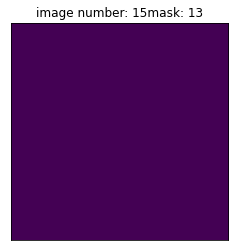

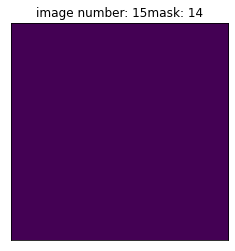

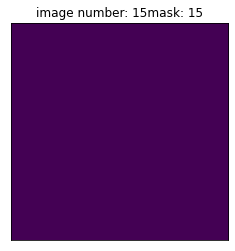

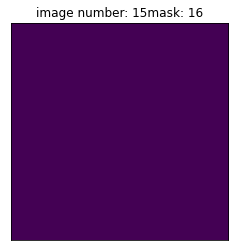

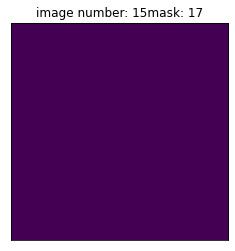

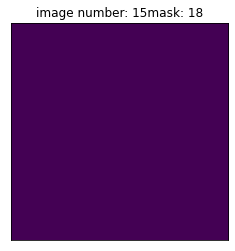

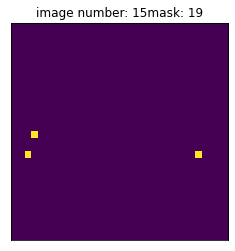

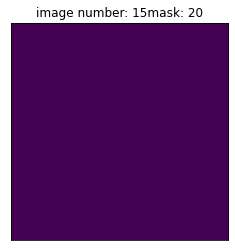

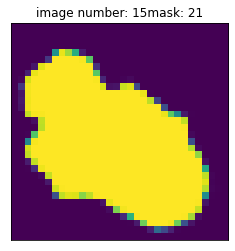

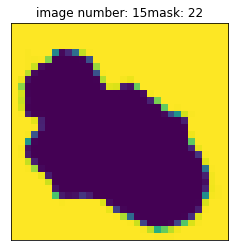

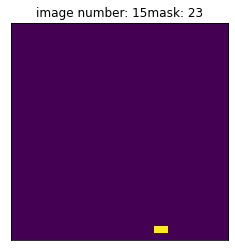

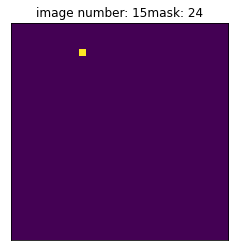

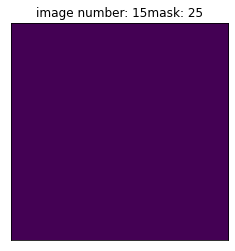

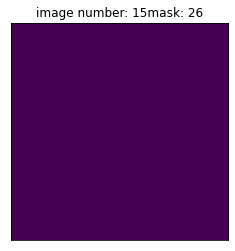

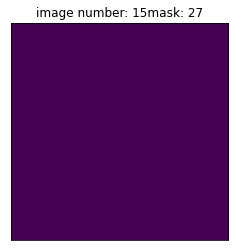

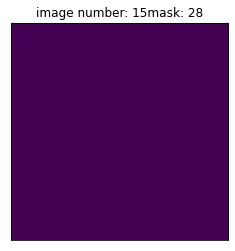

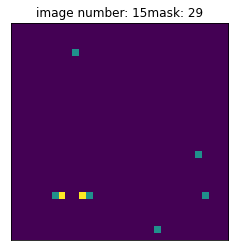

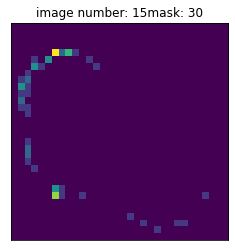

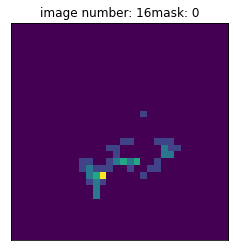

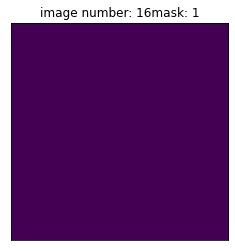

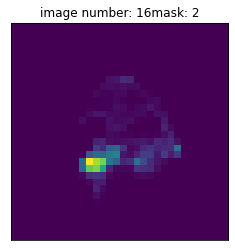

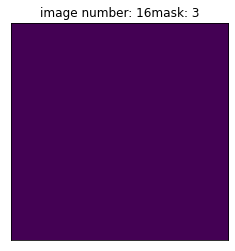

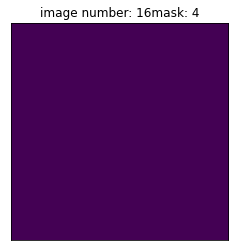

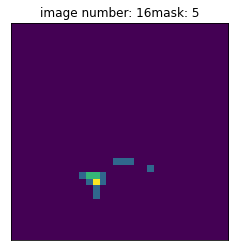

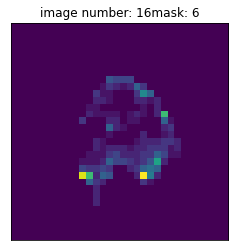

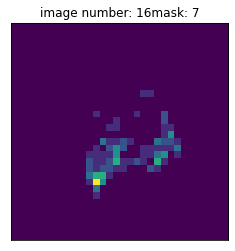

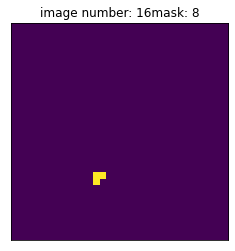

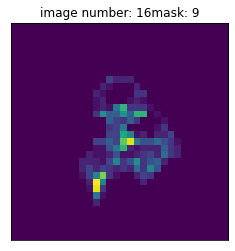

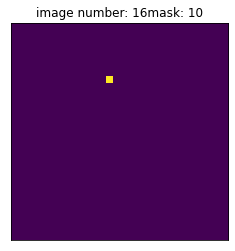

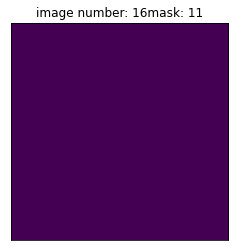

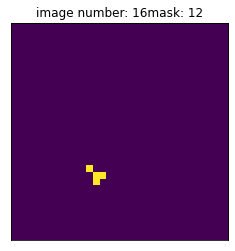

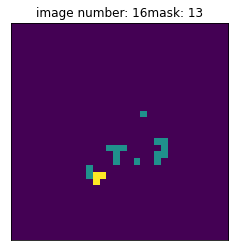

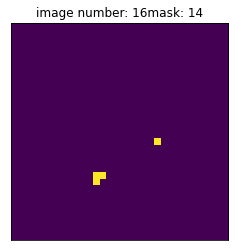

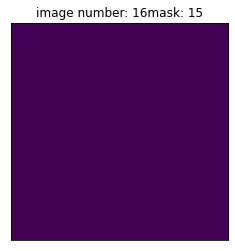

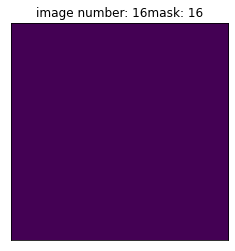

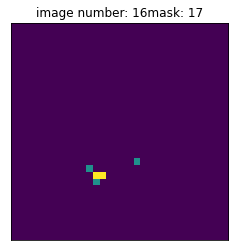

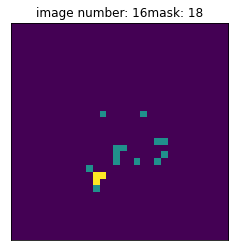

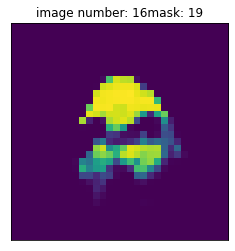

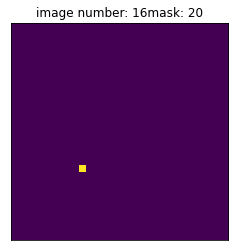

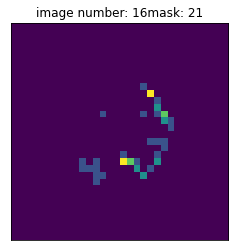

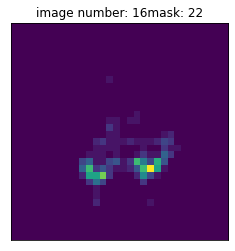

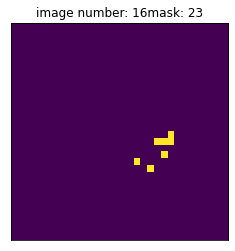

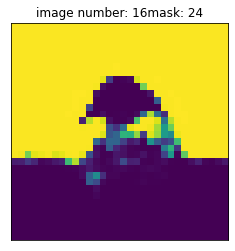

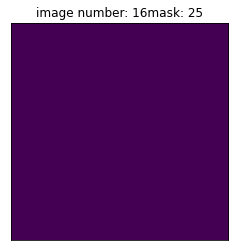

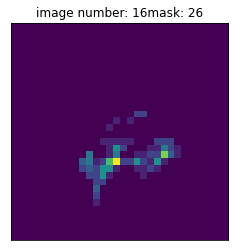

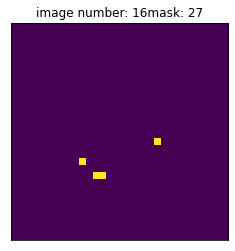

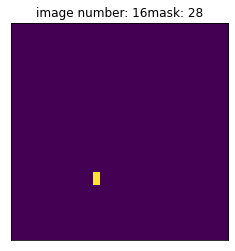

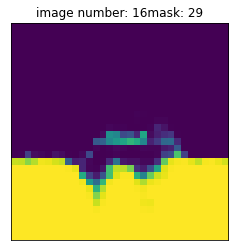

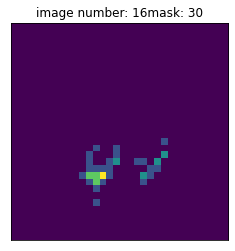

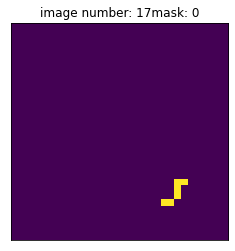

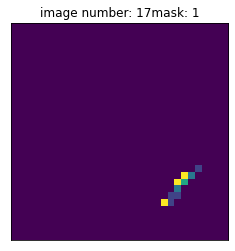

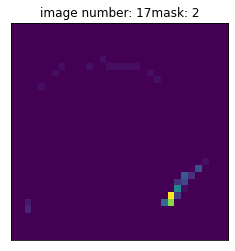

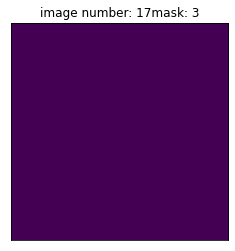

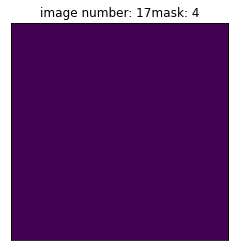

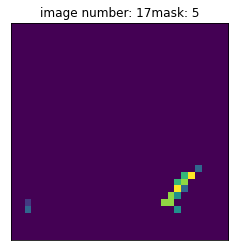

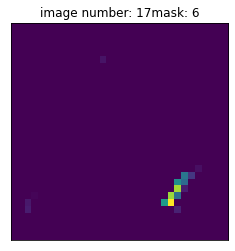

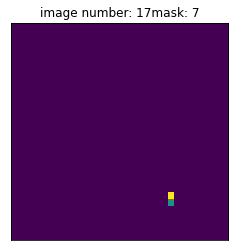

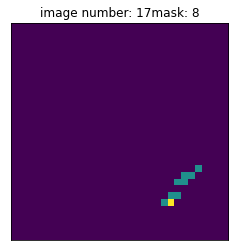

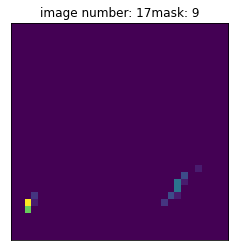

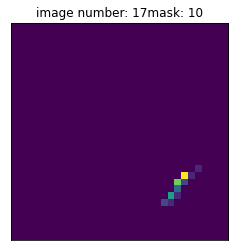

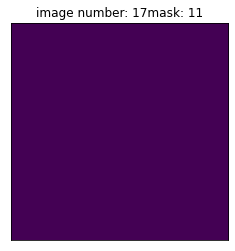

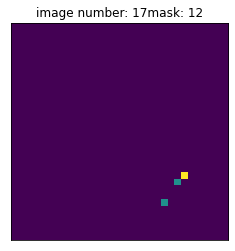

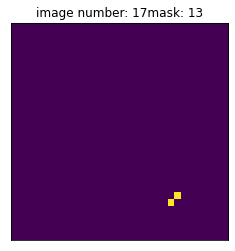

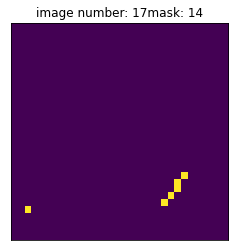

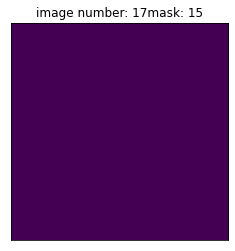

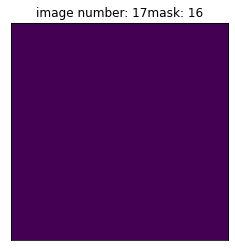

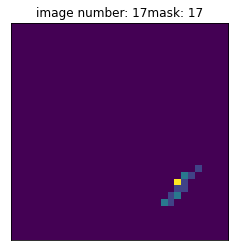

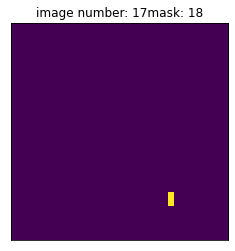

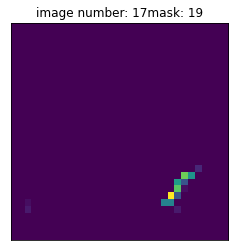

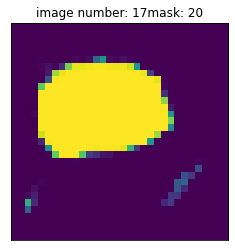

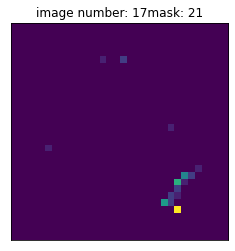

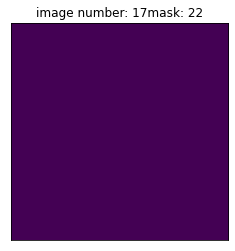

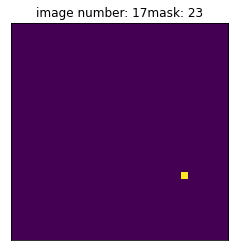

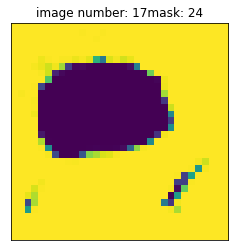

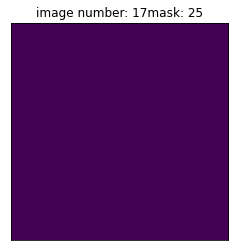

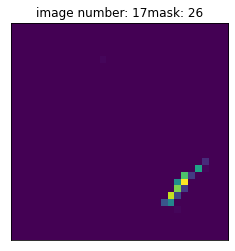

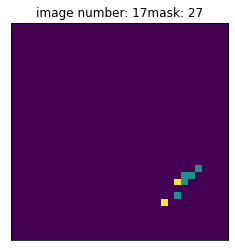

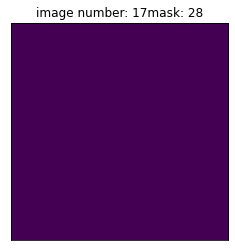

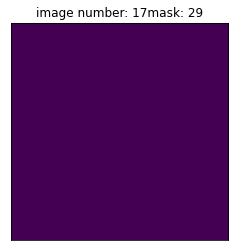

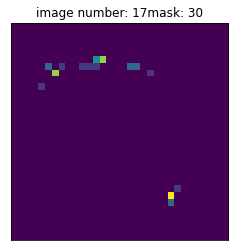

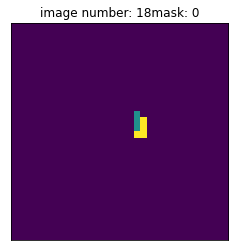

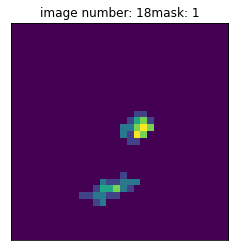

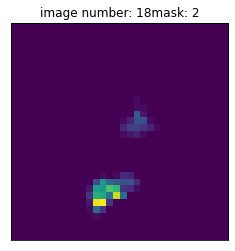

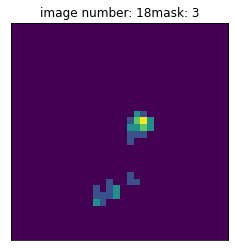

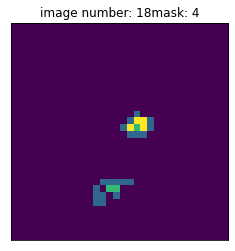

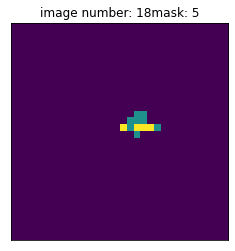

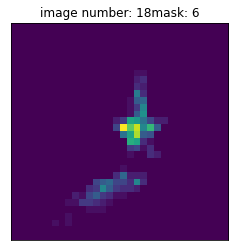

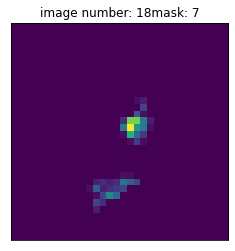

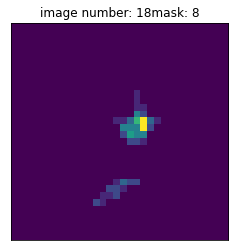

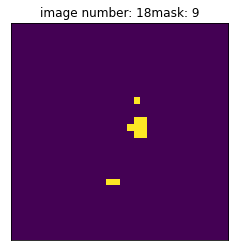

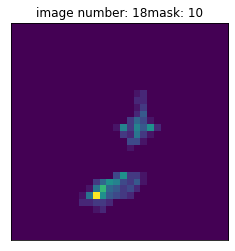

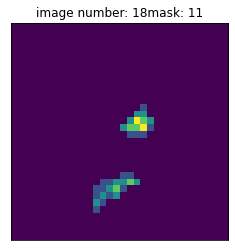

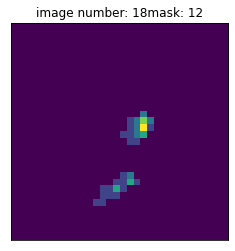

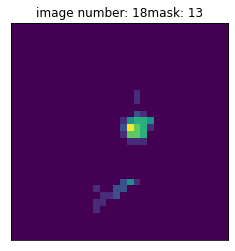

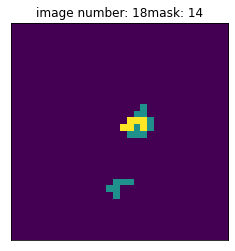

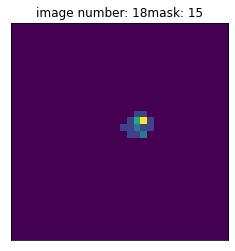

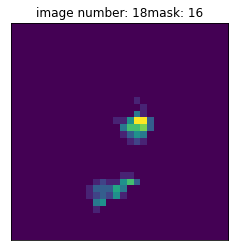

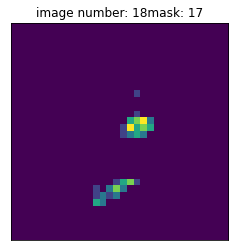

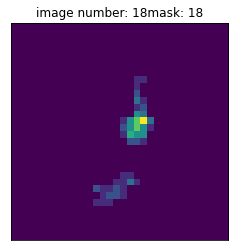

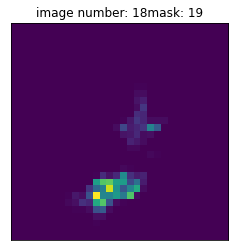

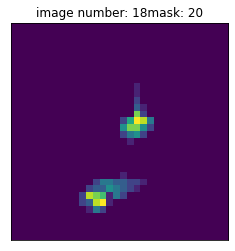

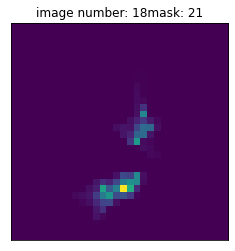

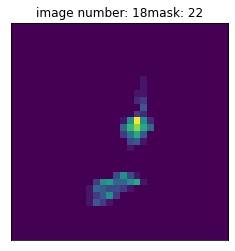

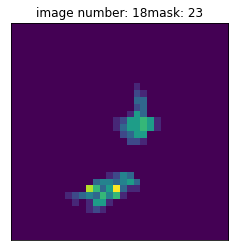

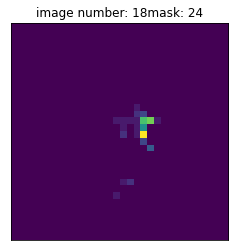

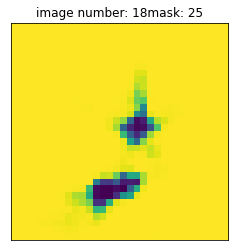

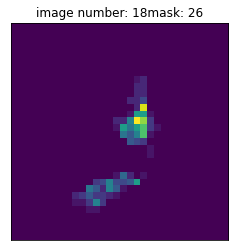

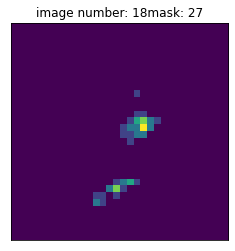

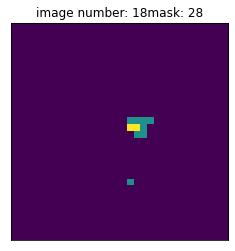

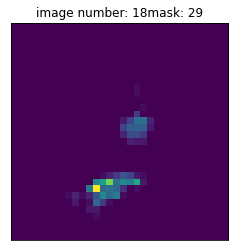

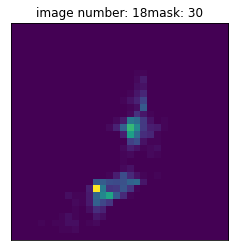

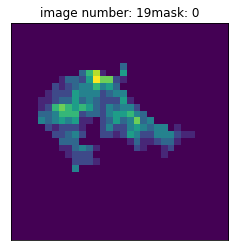

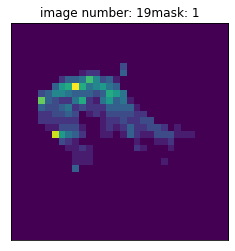

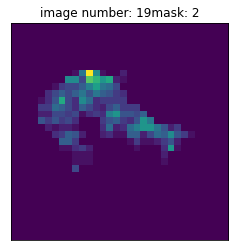

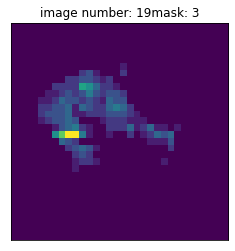

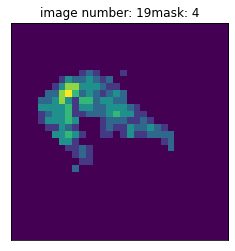

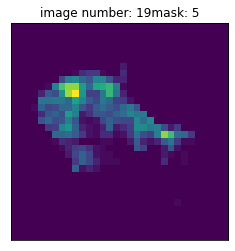

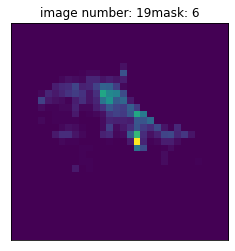

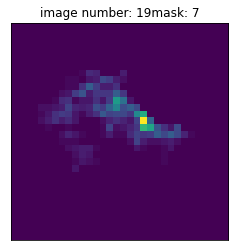

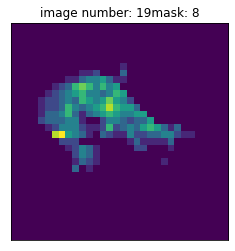

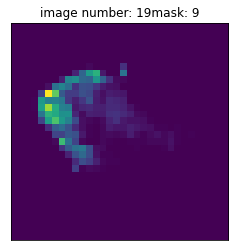

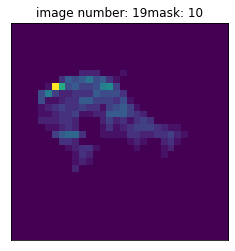

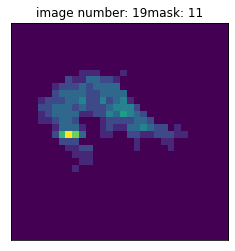

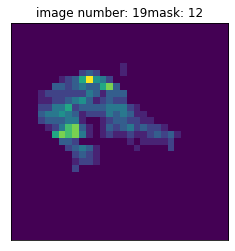

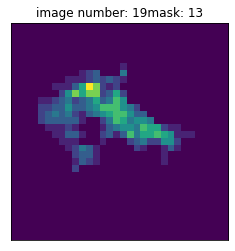

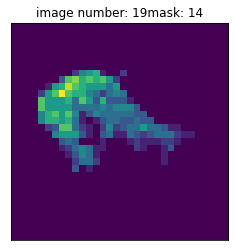

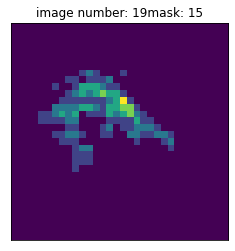

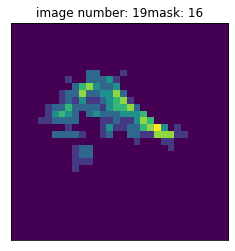

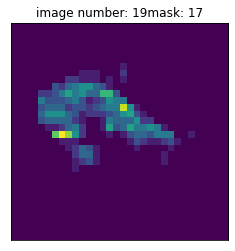

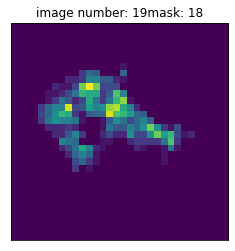

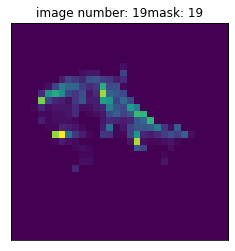

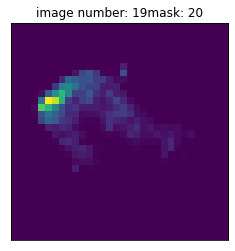

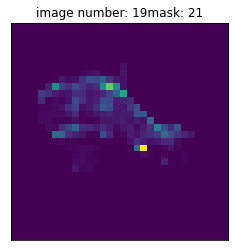

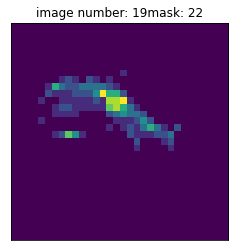

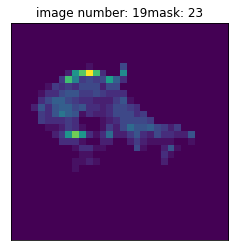

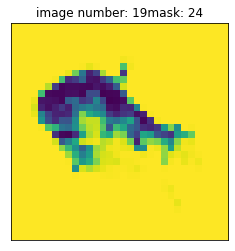

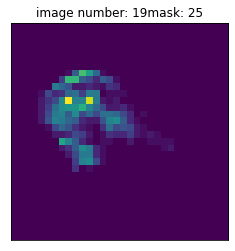

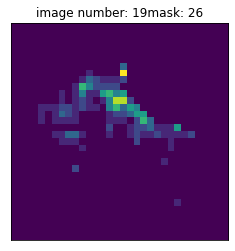

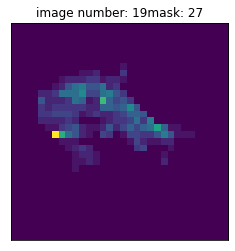

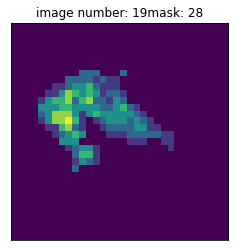

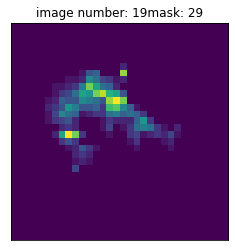

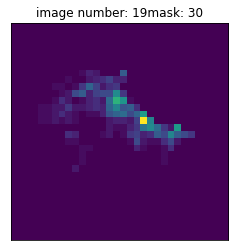

In [21]:

# import torchvision.transforms as T

        
# def calculate_metrics(model):

#     cal_metrics=calculate()
#     model.to(device)
# #     print("here")
#     with torch.set_grad_enabled(False):
#         model.eval()
# #         print("here1")
#         count=0
#         for batch,labels in train_gen:
#     #             print("here2")
#             count+=1
#             batch=batch.float().to(device)
# #             batch = F.normalize(batch,mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
#             predictions=model(batch)
#             predicted_masks=torch.argmax(predictions,dim=1).type(torch.float)
#             labels = labels.squeeze(1).to(device)
#             cal_metrics.add(predicted_masks.cpu(),labels.cpu()) 
#         print("Training set: miou,maccuracy,accuracy: ",cal_metrics.calculate_accuracy())

#     cal_metrics_=calculate()
#     with torch.set_grad_enabled(False):
#         model.eval()
# #         print("here1")
#         count=0
#         for batch,labels in test_gen:
#     #             print("here2")
#             count+=1
#             batch=batch.float().to(device)
# #             batch = F.normalize(batch,mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
#             predictions=model(batch)
#             predicted_masks=torch.argmax(predictions,dim=1).type(torch.float)
#             labels = labels.squeeze(1).to(device)
#             cal_metrics_.add(predicted_masks.cpu(),labels.cpu()) 
#         print("Testing set: miou,maccuracy,accuracy: ",cal_metrics_.calculate_accuracy())

# calculate_metrics(model)


import matplotlib.pyplot as plt
def show(imgs,Image_number,number):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0,i].set_title("image number: "+str(Image_number)+"mask: "+str(number))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
Image_num = 0
num = 0        
for mask in masks:
    if num>30:
        num = 0
        Image_num +=1
#     print(i)
    show(mask,Image_num,num)
    num+=1
    
# show(masks)

In [22]:
# import torchvision.transforms.functional as F

# testing_total_loss=0
# testing_loss=0
# model.to(device)
# model.eval()
# print("here")
# with torch.set_grad_enabled(False):
#     print("here1")
#     for batch,labels in test_gen:
# #             print("here2")
#         batch=batch.float().to(device)
#         labels=labels.float()
# #         labels = ((labels - labels.min()) * (1/(labels.max() - labels.min())*30))
# #         print("batch size", batch.size())
# #             batch,label=Variable(batch,requires_grad=True),Variable(labels,requires_grad=True)
# #             print(batch,label)
#         predictions=model(batch)
# #             print("predictions" ,predictions)
# #             print("predictions size",predictions.size())
# #             print("norm_pred",norm_pred.size())
# #         npred = torch.argmax(predictions.squeeze(),dim=1)
#         predictions = predictions.type(torch.FloatTensor)
#         npred = torch.nn.functional.softmax(predictions,dim =1).to(device)
#         print("np ", npred.size())
#         labels = labels.squeeze(1).to(device)

#         pred_loss = lossfunc(npred,labels.long()) 
# #         testing_loss.append(pred_loss)
#         print("pred_loss",pred_loss)
# #         print("batch[0]",batch[0])
#         masks = [
#             npred[img_idx,sem_class_to_idx[cls]]
#             for img_idx in range(batch.shape[0])
#             for cls in classes]
#         break

labels[5][100]

IndexError: index 100 is out of bounds for dimension 0 with size 32

In [25]:

# import matplotlib.pyplot as plt
# def show(imgs,Image_number,number):
#     if not isinstance(imgs, list):
#         imgs = [imgs]
#     fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
#     for i, img in enumerate(imgs):
#         img = img.detach()
#         img = F.to_pil_image(img)
#         axs[0,i].set_title("image number: "+str(Image_number)+"mask: "+str(number))
#         axs[0, i].imshow(np.asarray(img))
#         axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
# Image_num = 0
# num = 0        
# for mask in masks:
#     if num>30:
#         num = 0
#         Image_num +=1
# #     print(i)
#     show(mask,Image_num,num)
#     num+=1
    
# # show(masks)

import torchvision.transforms as T

transform = T.ToPILImage()
image = transform(images_test[23])
image
classes_test[23]

array(['crab_sem_seg_gt'], dtype='<U15')

In [ ]:
# import torchvision.transforms as T

# transform = T.ToPILImage()
# image = transform(labels[15].float())
# image